In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
%pip install sktime
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install statsmodels
%pip install scikit-learn
%pip install ipywidgets
%pip install jupyter
%pip install git+https://github.com/amazon-science/chronos-forecasting.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-kq6xjy7_
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-kq6xjy7_
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit eb7bdfc047de3e7af972b4ee7cf23a7968b7daa3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (py

## introduction

We'll be covering three main sections:

1️⃣ *Data Preparation and Exploration*

2️⃣ *Model Building and Evaluation*

3️⃣ *Advanced Techniques and Comparison*


🛠️ Libraries: `pandas`, `numpy`, `statsmodels`, `sklearn`, `tsbootstrap`, `sktime`, `chronos`


In [5]:
from matplotlib import pyplot as plt

# Set global matplotlib parameters
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

# Additional parameters for better visibility on dark background
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['grid.color'] = '#555555'
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'

### Section 1: Data Preparation and Exploration

#### 1.1 Loading Time Series Data

Using airlines dataset from `sktime`:
- Monthly totals of international airline passengers
- 1949 to 1960
- Classic dataset for time series analysis

            passengers
Period                
1949-01-01       112.0
1949-02-01       118.0
1949-03-01       132.0
1949-04-01       129.0
1949-05-01       121.0


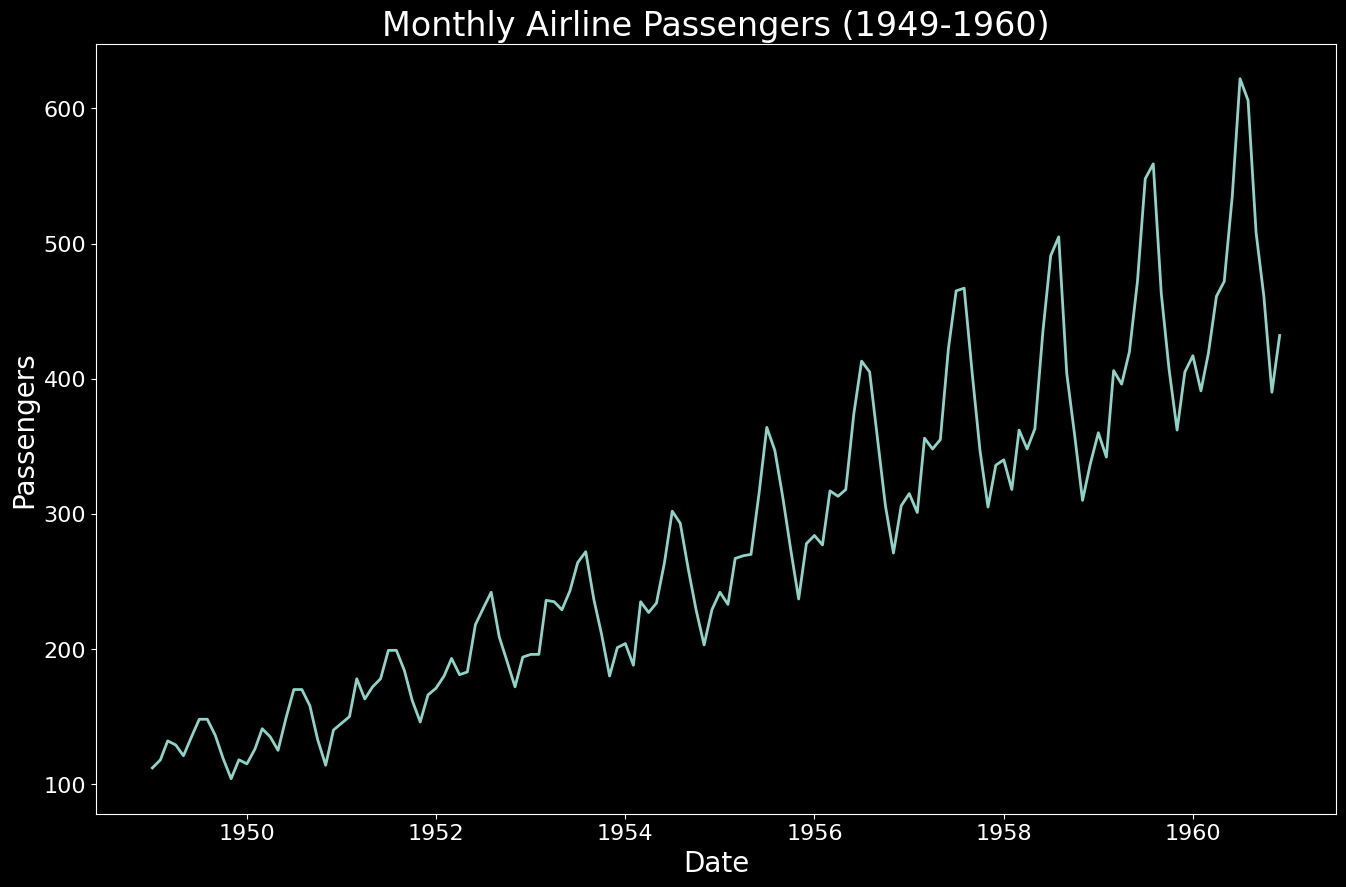

In [6]:

from sktime.datasets import load_airline
import pandas as pd

# Load the airline passengers dataset
y = load_airline()

# Convert to pandas DataFrame for easier manipulation
df = pd.DataFrame({'passengers': y})

# Convert PeriodIndex to DatetimeIndex for easier plotting
df.index = df.index.to_timestamp()

# Display first few rows
print(df.head())

# Plot the data
plt.figure()
plt.plot(df.index, df['passengers'])
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.show()

#### 1.2 Time Series Components

Main components:
1. Trend
2. Seasonality
3. Residual (noise)

Understanding these helps in forecasting.

#### 1.3 Stationarity

Stationary series:
- Constant statistical properties over time
- Easier to model and forecast

Often need to make series stationary before analysis.

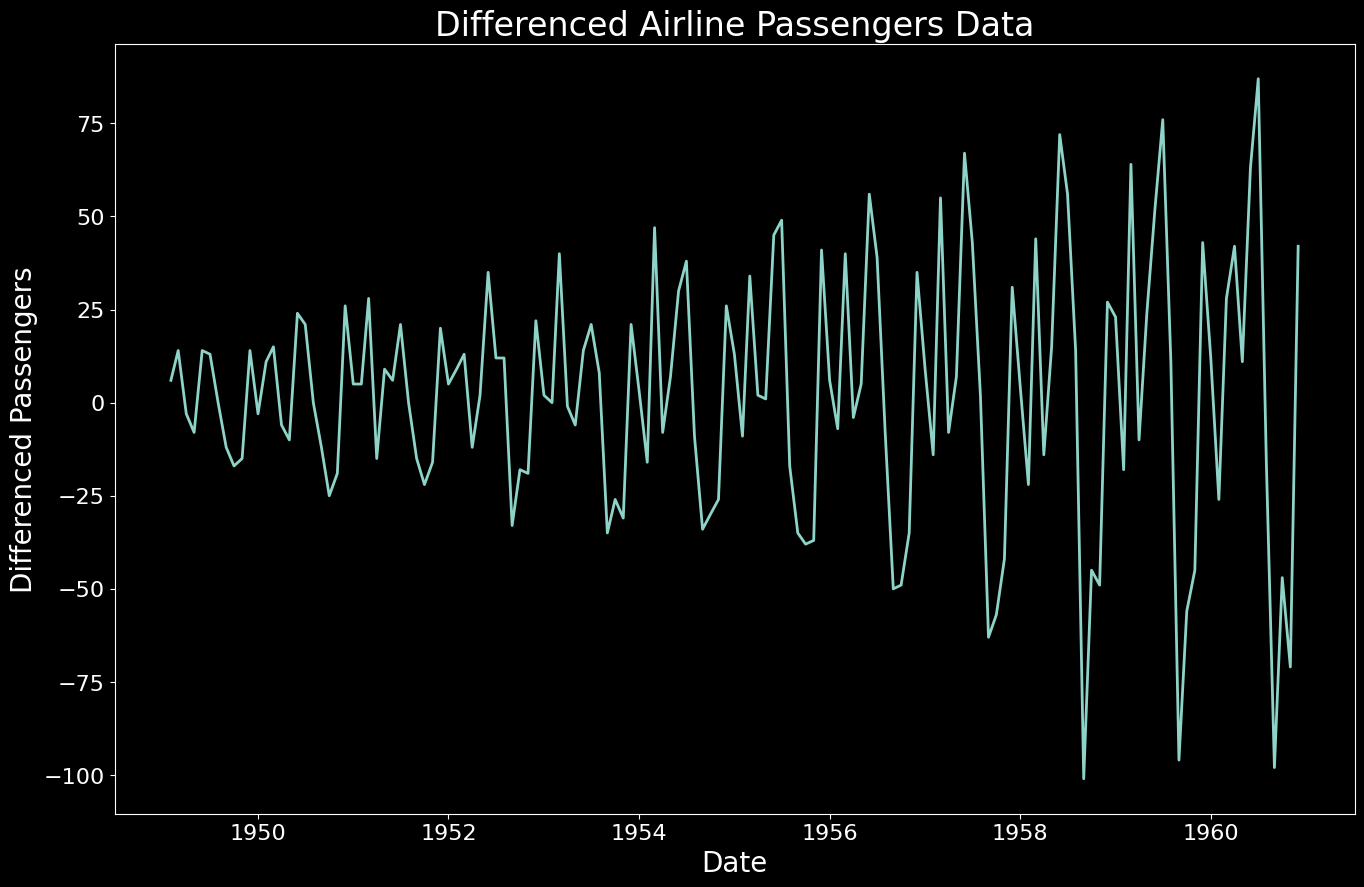

In [7]:
# Apply differencing to make the series more stationary
df_diff = df.diff().dropna()

# Plot the differenced series
plt.close('all')
plt.figure()
plt.plot(df_diff.index, df_diff)
plt.title('Differenced Airline Passengers Data')
plt.xlabel('Date')
plt.ylabel('Differenced Passengers')
plt.show()

#### 1.4 Autocorrelation and Partial Autocorrelation

ACF and PACF:
- Help identify patterns
- Guide model selection
- Crucial for traditional time series models (e.g., ARIMA)

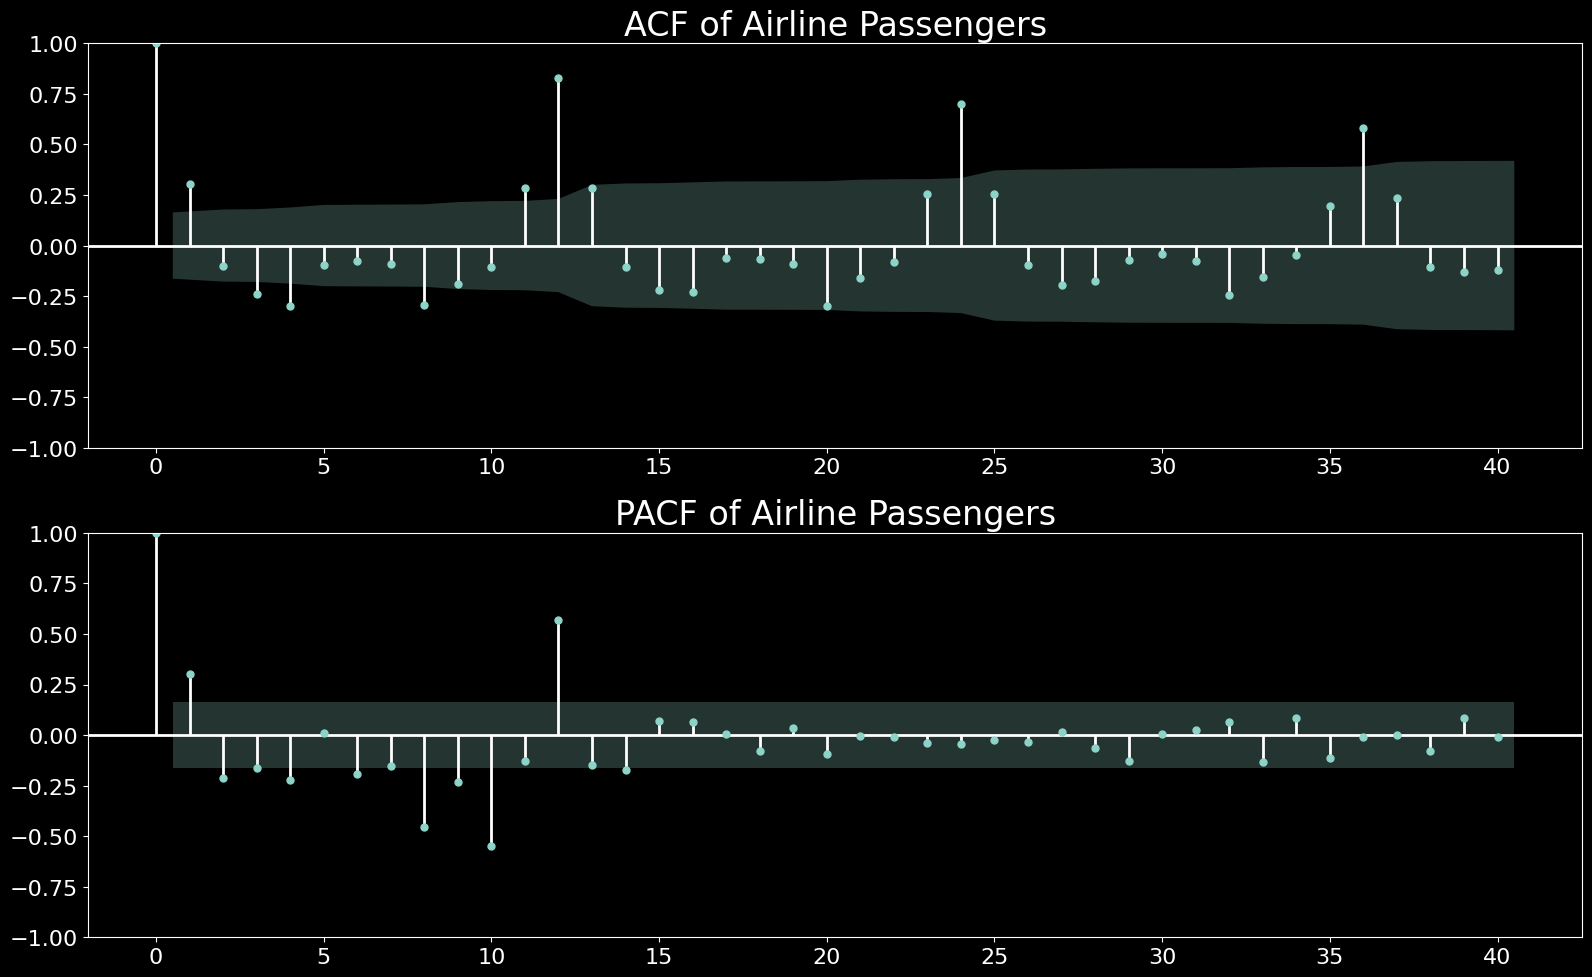

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create subplots for ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plot ACF
plot_acf(df_diff, ax=ax1, lags=40)
ax1.set_title("ACF of Airline Passengers")

# Plot PACF
plot_pacf(df_diff, ax=ax2, lags=40)
ax2.set_title("PACF of Airline Passengers")

plt.tight_layout()
plt.show()

### Section 2: Making and Evaluating Probabilistic Forecasts

In [9]:

# Split the data into training and test sets for later
df_train = df['1949-01-01':'1958-12-01']
df_test = df['1959-01-01':]
df_train, df_test

(            passengers
 Period                
 1949-01-01       112.0
 1949-02-01       118.0
 1949-03-01       132.0
 1949-04-01       129.0
 1949-05-01       121.0
 ...                ...
 1958-08-01       505.0
 1958-09-01       404.0
 1958-10-01       359.0
 1958-11-01       310.0
 1958-12-01       337.0
 
 [120 rows x 1 columns],
             passengers
 Period                
 1959-01-01       360.0
 1959-02-01       342.0
 1959-03-01       406.0
 1959-04-01       396.0
 1959-05-01       420.0
 1959-06-01       472.0
 1959-07-01       548.0
 1959-08-01       559.0
 1959-09-01       463.0
 1959-10-01       407.0
 1959-11-01       362.0
 1959-12-01       405.0
 1960-01-01       417.0
 1960-02-01       391.0
 1960-03-01       419.0
 1960-04-01       461.0
 1960-05-01       472.0
 1960-06-01       535.0
 1960-07-01       622.0
 1960-08-01       606.0
 1960-09-01       508.0
 1960-10-01       461.0
 1960-11-01       390.0
 1960-12-01       432.0)

#### Step 1: ARIMA, a workhorse of TS forecasting

#### 🌊 SARIMA Model

SARIMA: Seasonal AutoRegressive Integrated Moving Average

📊 Components:
- Non-Seasonal: AR(p), I(d), MA(q)
- Seasonal: SAR(P), SI(D), SMA(Q)

🧠 What they mean:
- AR(p): AutoRegressive - Uses past values to predict future
- I(d): Integrated - Differencing to make series stationary
- MA(q): Moving Average - Uses past forecast errors in prediction

🔢 Notation: SARIMA(p,d,q)(P,D,Q)m
- m = periods per season

🧠 Order selection: 
- Uses AIC/BIC, can be automated (e.g., AutoARIMA())

##### Auto ARIMA
- 🔄 Can handle non-stationary data
- 📊 Automatically determines differencing
- 💡 Pre-processing to stationarity can sometimes improve results

In [12]:
# Define common parameters
import numpy as np
from sktime.forecasting.base import ForecastingHorizon

monthly_params = {
    'sp': 12,            # Monthly seasonality
    'start_p': 0,        # Initial AR order
    'max_p': 3,          # Max AR order
    'start_q': 0,        # Initial MA order
    'max_q': 3,          # Max MA order
    'max_d': 2,          # Max differencing order
    'max_order': 5,      # Max p+q+P+Q
    'information_criterion': 'aicc',  # Use AICc for model selection
    'stepwise': True,    # Use faster stepwise selection
    'trace': False,      # Don't print warnings during fitting
    'method': 'mle',     # Use Maximum Likelihood Estimation
    'seasonal': True,    # Use seasonality
    'max_P': 2,          # Max seasonal AR order
    'max_Q': 2,          # Max seasonal MA order
    'start_P': 0,        # Initial seasonal AR order
    'start_Q': 0,        # Initial seasonal MA order
}


In [13]:
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

# step 1: data specification -- already done!

# step 2: specifying forecasting horizon
horizon = len(df_test)
fh = ForecastingHorizon(np.arange(1, horizon + 1))

# step 3: specifying the forecasting algorithm -- pipeline to the rescue!!
pipe = Differencer() * Deseasonalizer(sp=12) * Detrender() * StatsForecastAutoARIMA(**monthly_params)

# step 4: fitting the forecaster
pipe.fit(df_train, fh=fh)

TransformedTargetForecaster(steps=[Differencer(), Deseasonalizer(sp=12),
                                   Detrender(),
                                   StatsForecastAutoARIMA(max_p=3, max_q=3,
                                                          method='mle', sp=12,
                                                          start_P=0, start_Q=0,
                                                          start_p=0,
                                                          start_q=0)])

In [14]:
# Accessing the AutoARIMA model from the pipeline
fitted_autoarima_model = pipe.steps_[-1][1]
fitted_autoarima_params = fitted_autoarima_model.get_fitted_params()

# Accessing the key information from fitted_autoarima_params
order = fitted_autoarima_params['model']['arma'][:3]
seasonal_order = fitted_autoarima_params['model']['arma'][3:]
aic = fitted_autoarima_params['model']['aic']
bic = fitted_autoarima_params['model']['bic']
aicc = fitted_autoarima_params['model']['aicc']

# Displaying the selected parameters and additional information
print("ARIMA Model Summary:")
print("-" * 30)

# Non-Seasonal Order
print(f"Non-Seasonal Order: (p={order[0]}, d={order[1]}, q={order[2]})")

# Seasonal Order
print(f"Seasonal Order:     (P={seasonal_order[0]}, D={
      seasonal_order[1]}, Q={seasonal_order[2]}, s={seasonal_order[3]})")

# AIC, BIC, and AICc
print(f"AIC:                {aic:.2f}")
print(f"BIC:                {bic:.2f}")
print(f"AICc:               {aicc:.2f}")

ARIMA Model Summary:
------------------------------
Non-Seasonal Order: (p=1, d=0, q=1)
Seasonal Order:     (P=0, D=12, Q=0, s=0)
AIC:                908.15
BIC:                916.51
AICc:               908.36


In [16]:
# step 5: querying predictions
y_pred = pipe.predict()
y_pred


,passengers
1959-01-01,341.362533
1959-02-01,322.311401
1959-03-01,364.380931
1959-04-01,351.535708
1959-05-01,364.221485
1959-06-01,429.780018
1959-07-01,480.426278
1959-08-01,491.423833
1959-09-01,403.619750
1959-10-01,361.177432


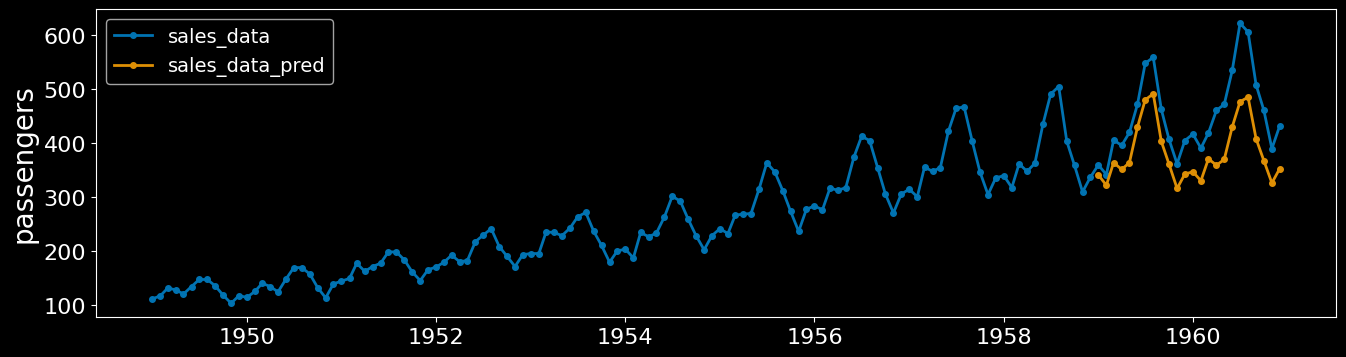

In [17]:
from sktime.utils import plotting

fig, ax = plotting.plot_series(
    df, y_pred, labels=["sales_data", "sales_data_pred"]
)

ax.legend()

#### 📊 step 2: probabilistic forecasting with `sktime`

🔮 Types in `sktime`:

1. 📏 Interval Forecasting
   - `predict_interval(fh=None, X=None, coverage=0.95)`
   - Gives range of likely outcomes
   - Example: Sales between $90k-$110k next month
   - Use: Budget planning, inventory management

2. 📈 Variance Forecasting
   - `predict_var(fh=None, X=None, cov=False)`
   - Measures spread of possible outcomes
   - Example: Sales forecast uncertainty of ±$10k
   - Use: Assessing forecast reliability, comparing models

3. 🎲 Distribution Forecasting
   - `predict_proba(fh=None, X=None, marginal=True)`
   - Full probability distribution of outcomes
   - Example: Complete sales probability curve
   - Use: Sophisticated decision-making, complex risk analysis

🔑 Key Differences:
- Intervals: Simple range
- Quantiles: Specific probability points
- Distribution: Complete probability picture

💡 Real-life Applications:
- Weather forecasting (rain probability)
- Financial market predictions
- Energy demand forecasting
- Supply chain optimization

-----------
##### `predict_interval` - interval predictions

Inputs:
- `fh` - forecasting horizon (not necessary if seen in `fit`)
- `coverage`, float or list of floats, default=`0.95`
nominal coverage(s) of the prediction interval(s) queried

Output: `pandas.DataFrame`
- Row index is `fh`
- Column has multi-index:
- 1st level = variable name from y in fit
- 2nd level = coverage fractions in `coverage`
- 3rd level = string "lower" or "upper"

Entries = forecasts of lower/upper interval at nominal coverage in 2nd lvl, for var in 1st lvl, for time in row

In [18]:
import pandas as pd 

# Get the prediction intervals
y_pred_ints = pipe.predict_interval(coverage=[0.95])

# concatenate `y_pred_ints` with `df_test`
y_pred_ints_concat = pd.concat([y_pred_ints, df_test], axis=1)

y_pred_ints_concat

,"(passengers, 0.95, lower)","(passengers, 0.95, upper)",passengers
1959-01-01,321.901178,360.823888,360.0
1959-02-01,283.170413,361.452388,342.0
1959-03-01,305.555415,423.206446,406.0
1959-04-01,273.025554,430.045862,396.0
1959-05-01,266.026690,462.416279,420.0
1959-06-01,311.900583,547.659454,472.0
1959-07-01,342.862202,617.990354,548.0
1959-08-01,334.175115,648.672550,559.0
1959-09-01,226.686391,580.553108,463.0
1959-10-01,164.559432,557.795431,407.0


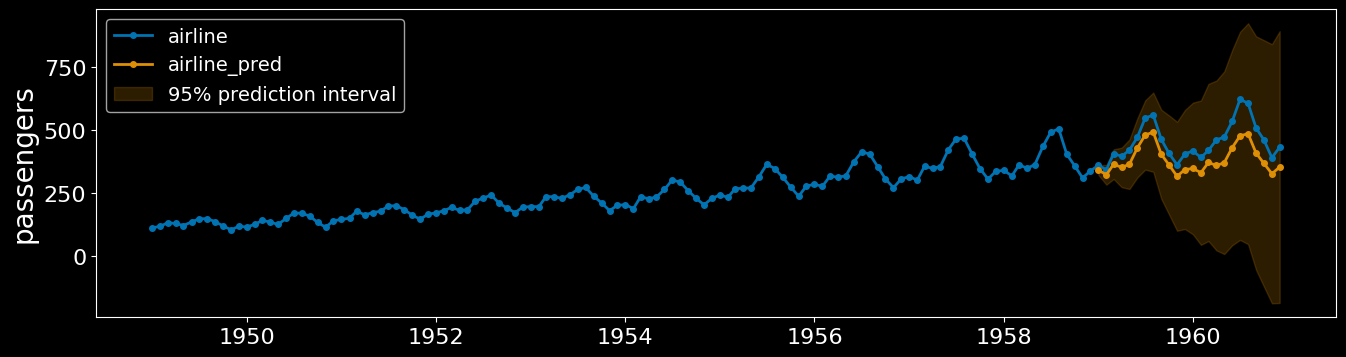

In [19]:

fig, ax = plotting.plot_series(
    df, y_pred, labels=["airline", "airline_pred"], pred_interval=y_pred_ints
)

ax.legend()

##### `predict_quantiles` - quantile forecasts

Inputs:
- `fh` - forecasting horizon (not necessary if seen in `fit`)
- `alpha`, float or list of floats, default = `[0.1, 0.9]`
quantile points at which quantiles are queried

Output: `pandas.DataFrame`
- Row index is `fh`
- Column has multi-index:
- 1st level = variable name from y in fit
- 2nd level = quantile points in `alpha`

In [21]:
# Get the prediction quantiles
y_pred_quantiles = pipe.predict_quantiles(alpha=[0.025, 0.5, 0.975])

# concatenate `y_pred_ints` with `df_test`
y_pred_quantiles_concat = pd.concat([y_pred_quantiles, df_test], axis=1)

y_pred_quantiles_concat

,"(passengers, 0.025)","(passengers, 0.5)","(passengers, 0.975)",passengers
1959-01-01,321.901178,341.362533,360.823888,360.0
1959-02-01,283.170413,322.311401,361.452388,342.0
1959-03-01,305.555415,364.380931,423.206446,406.0
1959-04-01,273.025554,351.535708,430.045862,396.0
1959-05-01,266.026690,364.221485,462.416279,420.0
1959-06-01,311.900583,429.780018,547.659454,472.0
1959-07-01,342.862202,480.426278,617.990354,548.0
1959-08-01,334.175115,491.423833,648.672550,559.0
1959-09-01,226.686391,403.619750,580.553108,463.0
1959-10-01,164.559432,361.177432,557.795431,407.0


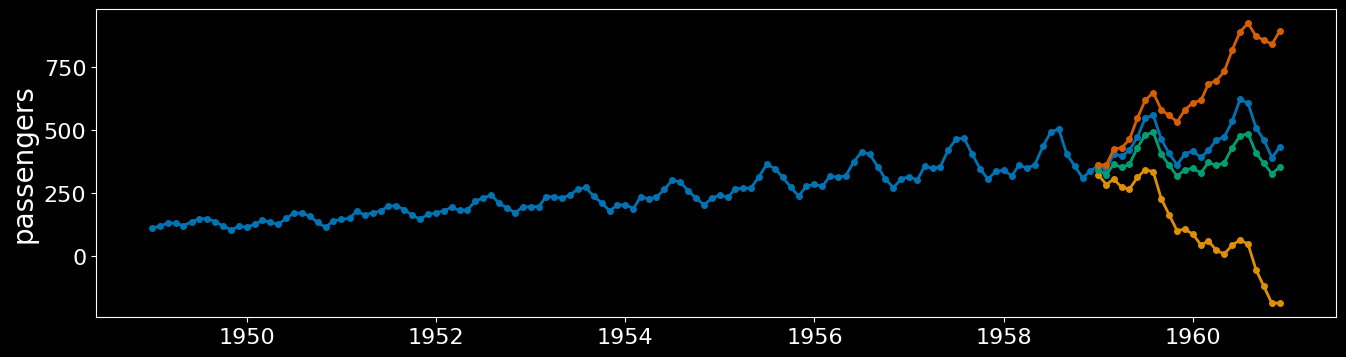

In [22]:
from sktime.utils import plotting

columns = [y_pred_quantiles[i] for i in y_pred_quantiles.columns]
fig, ax = plotting.plot_series(df, *columns)

##### `predict_proba` - distribution forecasts aka "full" probabilistic forecasts

Inputs:
- `fh` - forecasting horizon (not necessary if seen in `fit`)

Output: `skpro` `Distribution` object

In [23]:
y_pred_dist = pipe.predict_proba()
y_pred_dist

Normal(columns=Index(['passengers'], dtype='object'),
       index=DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01', '1959-11-01', '1959-12-01',
               '1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '196...
1959-07-01   70.187043
1959-08-01   80.230412
1959-09-01   90.273780
1959-10-01  100.317149
1959-11-01  110.360518
1959-12-01  120.403887
1960-01-01  133.256228
1960-02-01  146.164886
1960-03-01  159.074812
1960-04-01  171.984766
1960-05-01  184.894721
1960-06-01  197.804676
1960-07-01  210.714631
1960-08-01  223.624585
1960-09-01  236.534540
1960-10-01  249.444495
1960-11-01  262.354450
1960-12-01  275.264404)

In [87]:
# obtaining quantiles
y_pred_dist_quantiles = y_pred_dist.quantile([0.025, 0.5, 0.975])

# concatenating `y_pred_dist_quantiles` with `df_test`
y_pred_dist_quantiles_concat = pd.concat([y_pred_dist_quantiles, df_test], axis=1)

y_pred_dist_quantiles_concat

,"(passengers, 0.025)","(passengers, 0.5)","(passengers, 0.975)",passengers
1959-01-01,321.901178,341.362533,360.823888,360.0
1959-02-01,283.170413,322.311401,361.452388,342.0
1959-03-01,305.555415,364.380931,423.206446,406.0
1959-04-01,273.025554,351.535708,430.045862,396.0
1959-05-01,266.026690,364.221485,462.416279,420.0
1959-06-01,311.900583,429.780018,547.659454,472.0
1959-07-01,342.862202,480.426278,617.990354,548.0
1959-08-01,334.175115,491.423833,648.672550,559.0
1959-09-01,226.686391,403.619750,580.553108,463.0
1959-10-01,164.559432,361.177432,557.795431,407.0


##### a note on consistency of methods

Outputs of `predict_interval`, `predict_quantiles`, `predict_var`, `predict_proba` are *typically* but not *necessarily* consistent with each other!

Consistency is weak interface requirement but not strictly enforced.

-------
#### Step 3a: Evaluating Forecasts: Point-Prediction Metrics

- MSPE (Mean Squared Percentage Error)
  * Range: [0, ∞)
  * Interpretation: 
    - MASE < 1: Forecast better than naive forecast
    - MASE = 1: Performance equivalent to naive forecast
    - MASE > 1: Naive forecast better
  * Advantage: Scale-independent, suitable for comparing across different datasets

- MAPE (Mean Absolute Percentage Error)
  * Range: [0, ∞)
  * Typically expressed as a percentage
  * Interpretation: Lower is better
  * Caution: Biased for low values, undefined for zero values


In [24]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanSquaredPercentageError

# Calculate MAPE
mape = MeanAbsolutePercentageError()
mape_value = mape(y_true=df_test, y_pred=y_pred)

# Calculate MSPE
mspe = MeanSquaredPercentageError()
mspe_value = mspe(y_true=df_test, y_pred=y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.4f}")
print(f"Mean Squared Percentage Error (MSPE): {mspe_value:.4f}")

Mean Absolute Percentage Error (MAPE): 0.1481
Mean Squared Percentage Error (MSPE): 0.0244


#### Step 3b: Evaluating Forecasts: Key Concepts in Probabilistic Forecasting

1. 📏 Coverage

What it is:
- Measures how often the true value falls within a prediction interval
- Typically assessed for specific confidence levels (e.g., 95% interval)

Example:
- A 95% prediction interval should contain the true value 95% of the time

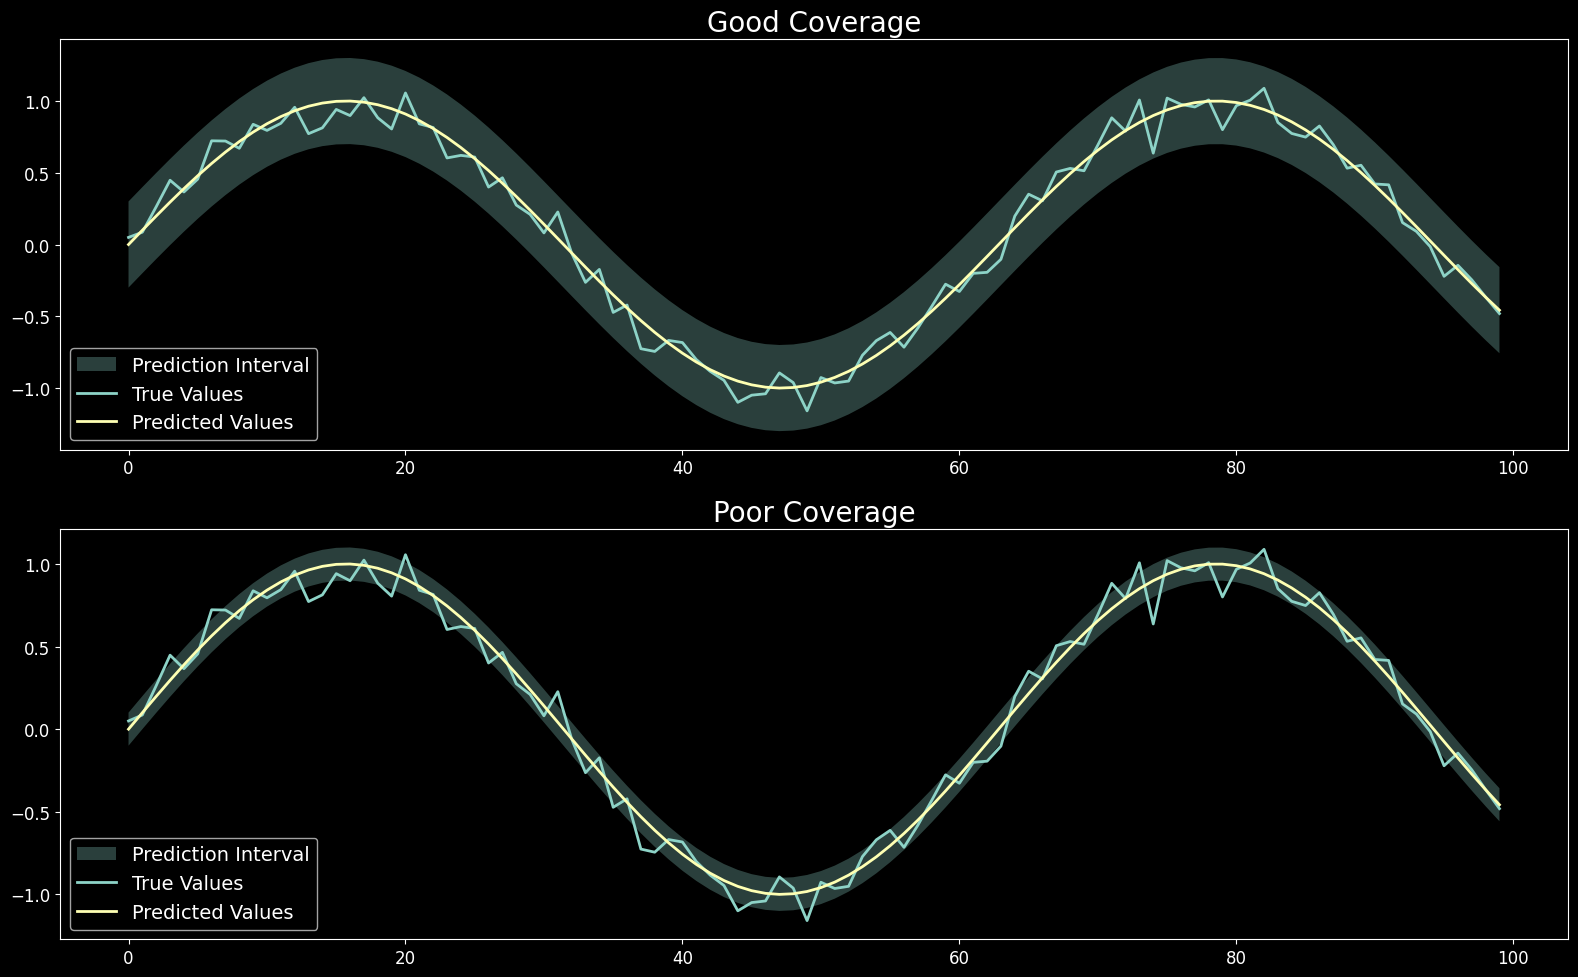

In [59]:
# Coverage Visualization
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
x = np.arange(100)
y_true = np.sin(x * 0.1) + np.random.normal(0, 0.1, 100)
y_pred = np.sin(x * 0.1)

# Good coverage
lower_good = y_pred - 0.3
upper_good = y_pred + 0.3

# Poor coverage
lower_poor = y_pred - 0.1
upper_poor = y_pred + 0.1

plt.figure()

plt.subplot(2, 1, 1)
plt.fill_between(x, lower_good, upper_good, alpha=0.3,
                    label='Prediction Interval')
plt.plot(x, y_true, label='True Values')
plt.plot(x, y_pred, label='Predicted Values')
plt.title('Good Coverage')
plt.legend()

plt.subplot(2, 1, 2)
plt.fill_between(x, lower_poor, upper_poor, alpha=0.3,
                    label='Prediction Interval')
plt.plot(x, y_true, label='True Values')
plt.plot(x, y_pred, label='Predicted Values')
plt.title('Poor Coverage')
plt.legend()

plt.tight_layout()



Importance:
- Indicates reliability of interval forecasts
- Crucial for risk assessment and decision-making

-----------------
2. 📐 Sharpness

What it is:
- Refers to the width of prediction intervals
- Measures how precise or focused the forecast is

Example:
- A forecast predicting temperature between 20-22°C is sharper than 18-24°C

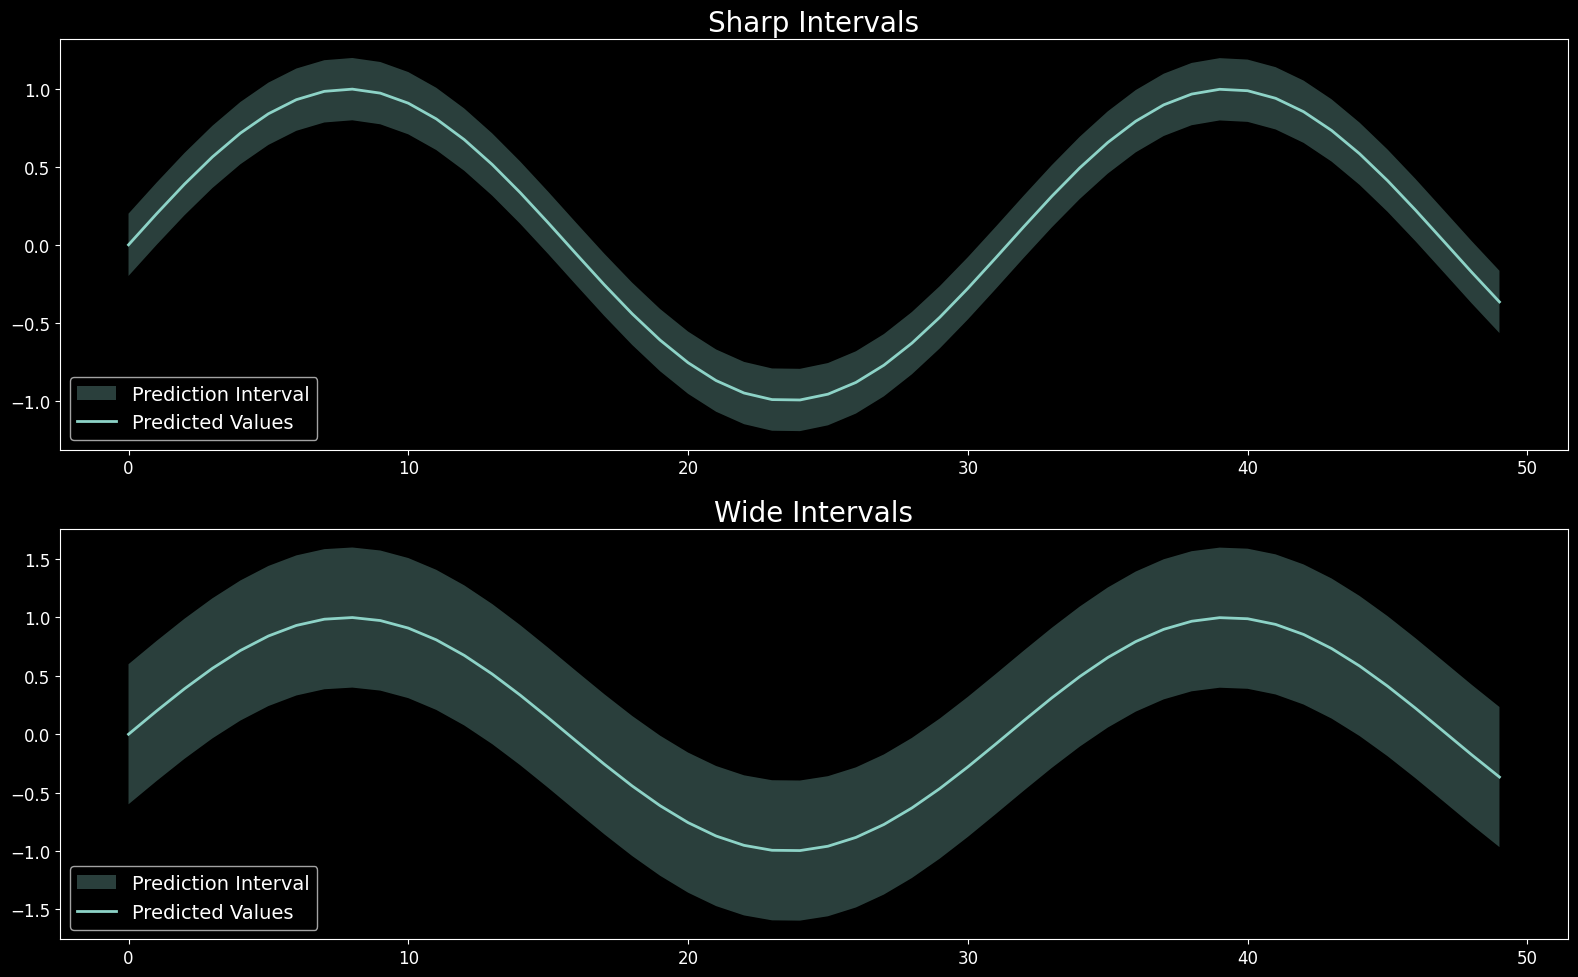

In [60]:
# Sharpness Visualization
x = np.arange(50)
y_pred = np.sin(x * 0.2)

# Sharp intervals
lower_sharp = y_pred - 0.2
upper_sharp = y_pred + 0.2

# Wide intervals
lower_wide = y_pred - 0.6
upper_wide = y_pred + 0.6

plt.figure()

plt.subplot(2, 1, 1)
plt.fill_between(x, lower_sharp, upper_sharp,
                    alpha=0.3, label='Prediction Interval')
plt.plot(x, y_pred, label='Predicted Values')
plt.title('Sharp Intervals')
plt.legend()

plt.subplot(2, 1, 2)
plt.fill_between(x, lower_wide, upper_wide, alpha=0.3,
                    label='Prediction Interval')
plt.plot(x, y_pred, label='Predicted Values')
plt.title('Wide Intervals')
plt.legend()

plt.tight_layout()


Importance:
- Sharper forecasts are more informative if well-calibrated
- Balance needed between sharpness and coverage


3. 🎯 Calibration

What it is:
- Measures how well predicted probabilities match observed frequencies
- Applies to the entire probabilistic forecast

Example:
- If we predict a 70% chance of rain 100 times, it should rain about 70 times

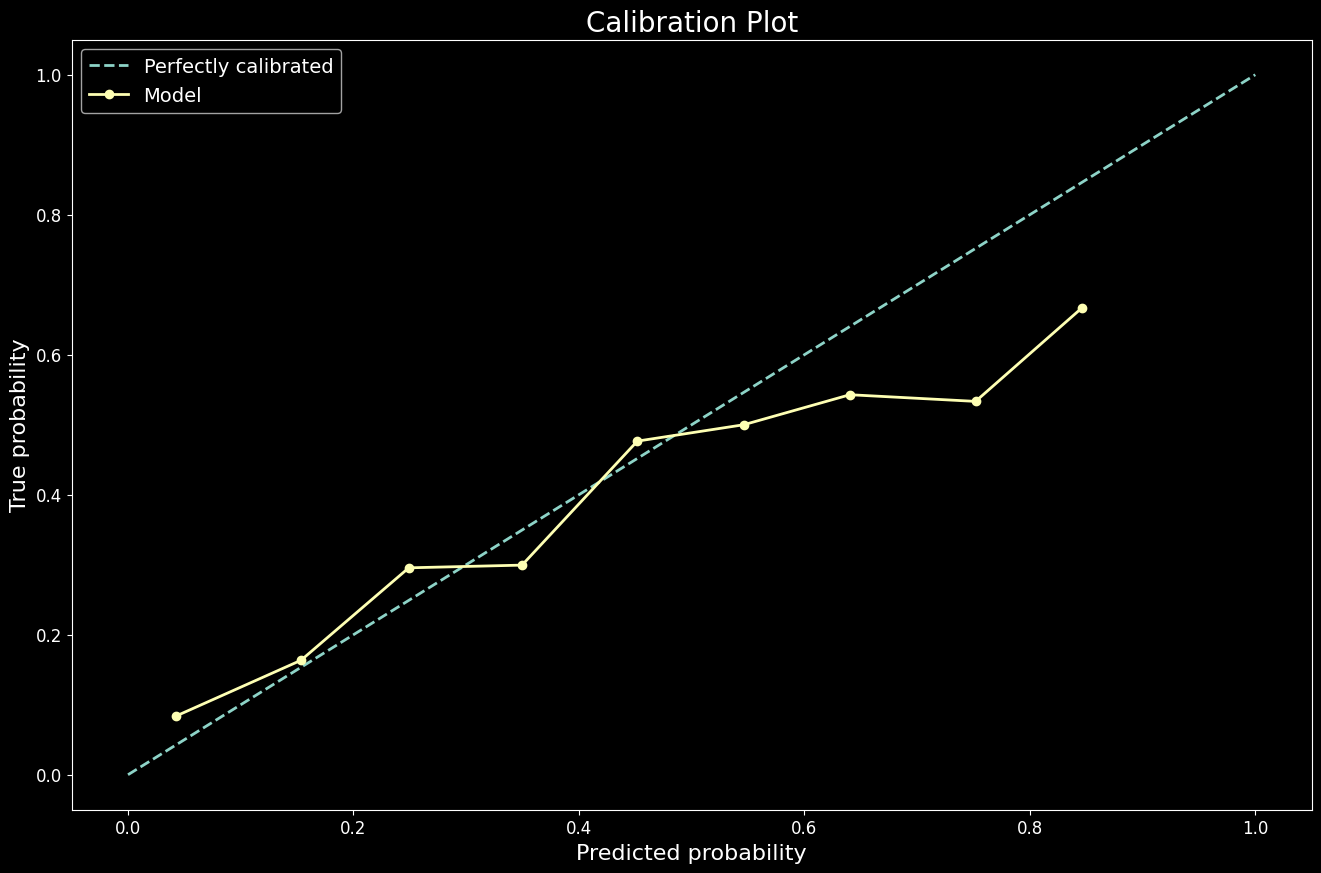

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Calibration Plot
np.random.seed(42)
n_samples = 1000

# Generate some example data
true_probs = np.random.beta(2, 5, n_samples)
predicted_probs = true_probs + np.random.normal(0, 0.1, n_samples)
predicted_probs = np.clip(predicted_probs, 0, 1)

# Generate actual outcomes based on true probabilities
outcomes = np.random.binomial(1, true_probs)

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(
    outcomes, predicted_probs, n_bins=10)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Plot')
plt.legend()


Importance:
- Crucial for overall forecast reliability
- Well-calibrated forecasts provide trustworthy probabilities

-----------
3. 📊 Probability Integral Transform (PIT) Diagram

What it is:
- Visual tool to assess calibration of continuous probabilistic forecasts
- Shows distribution of observed values within predicted distributions

Example:
- If forecast is perfect, observed values should be uniformly distributed within predicted quantiles

💡 Pro Tip: Use PIT diagrams alongside calibration plots for a comprehensive assessment of your probabilistic forecasts!

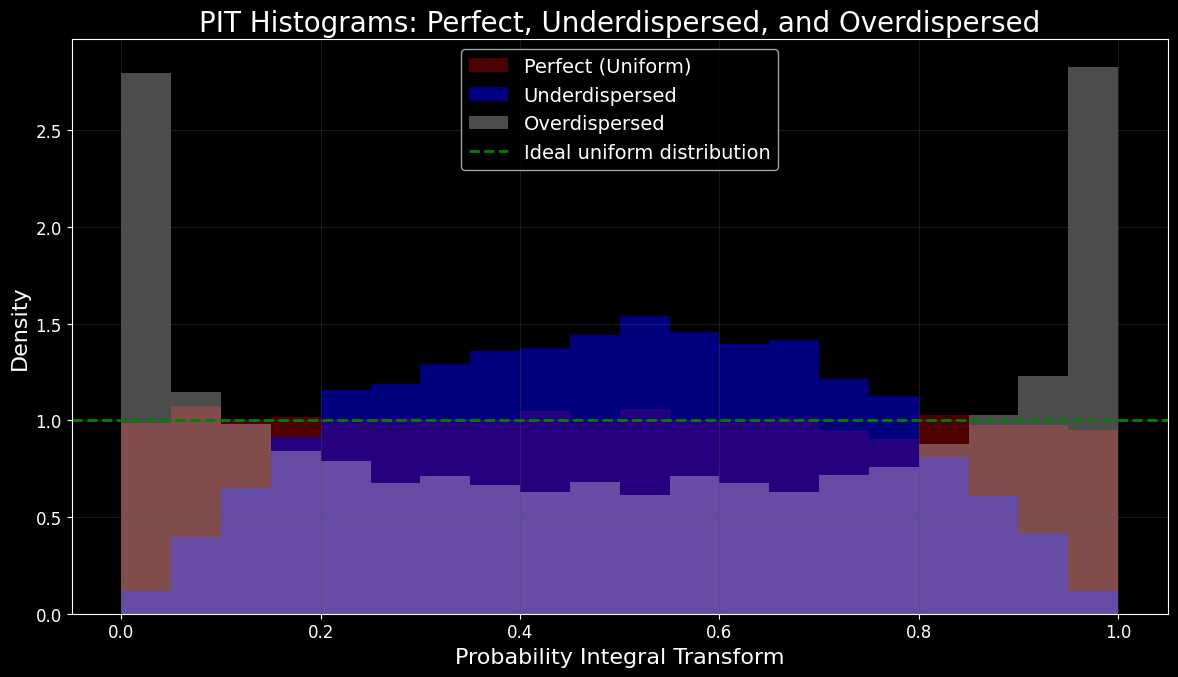

In [186]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 10000

# Generate data for three scenarios
perfect_pit = np.random.uniform(0, 1, n_samples)
underdispersed_pit = beta.rvs(2, 2, size=n_samples)
overdispersed_pit = beta.rvs(0.5, 0.5, size=n_samples)

# Create the plot
plt.figure(figsize=(12, 7))

# Plot histograms
bins = np.linspace(0, 1, 21)
plt.hist(perfect_pit, bins=bins, alpha=0.3,
         density=True, label='Perfect (Uniform)', color='red')
plt.hist(underdispersed_pit, bins=bins, alpha=0.5,
         density=True, label='Underdispersed', color='b')
plt.hist(overdispersed_pit, bins=bins, alpha=0.3,
         density=True, label='Overdispersed', color='white')

# Add the ideal uniform distribution line
plt.axhline(y=1, color='green', linestyle='--', label='Ideal uniform distribution')

# Customize the plot
plt.xlabel('Probability Integral Transform')
plt.ylabel('Density')
plt.title('PIT Histograms: Perfect, Underdispersed, and Overdispersed')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


🔍 Interpretation:
- Uniform distribution (matching red line) = well-calibrated forecast
- U-shape = underdispersed forecast (too narrow)
- Inverse U-shape = overdispersed forecast (too wide)
- Skew = biased forecast (systematic over/underestimation)

Importance:
- Reveals biases and miscalibration in probabilistic forecasts
- Helps identify specific areas where model needs improvement


---------------------
5. 🔍 Resolution

What it is:
- Ability to discriminate between different outcomes
- Measures how much forecasts vary across different situations

Example:
- High resolution: Forecast probabilities range from 10% to 90% across different days
- Low resolution: Always forecasting around 50% chance, regardless of conditions

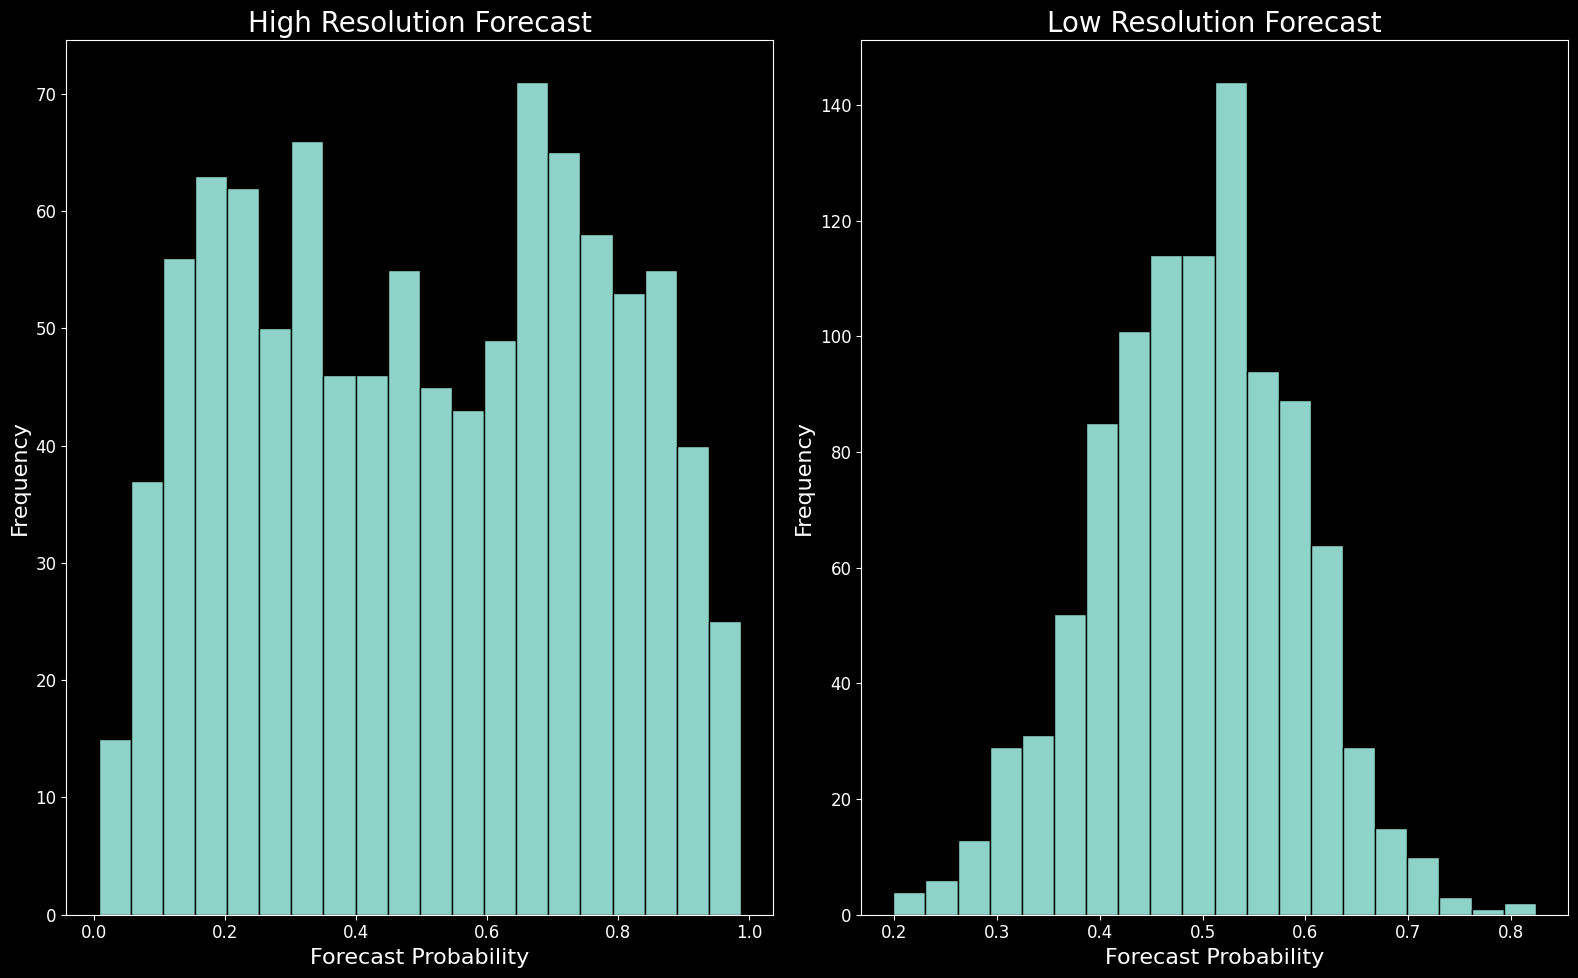

In [62]:
np.random.seed(42)
n_samples = 1000

# Generate two sets of forecast probabilities
high_resolution = np.concatenate([
    np.random.beta(2, 5, n_samples // 2),
    np.random.beta(5, 2, n_samples // 2)
])
low_resolution = np.random.normal(0.5, 0.1, n_samples)
low_resolution = np.clip(low_resolution, 0, 1)

plt.figure()

plt.subplot(1, 2, 1)
plt.hist(high_resolution, bins=20, edgecolor='black')
plt.title('High Resolution Forecast')
plt.xlabel('Forecast Probability')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(low_resolution, bins=20, edgecolor='black')
plt.title('Low Resolution Forecast')
plt.xlabel('Forecast Probability')
plt.ylabel('Frequency')

plt.tight_layout()


------------------------------

#### Step 3c: Evaluating Forecasts: Probabilistic Metrics
1. 📊 Pinball Loss
- Range: [0, ∞)
- Assesses entire prediction interval, not just point forecast
- Penalizes too narrow and too wide intervals
- Interpretation: Lower values indicate better calibrated intervals

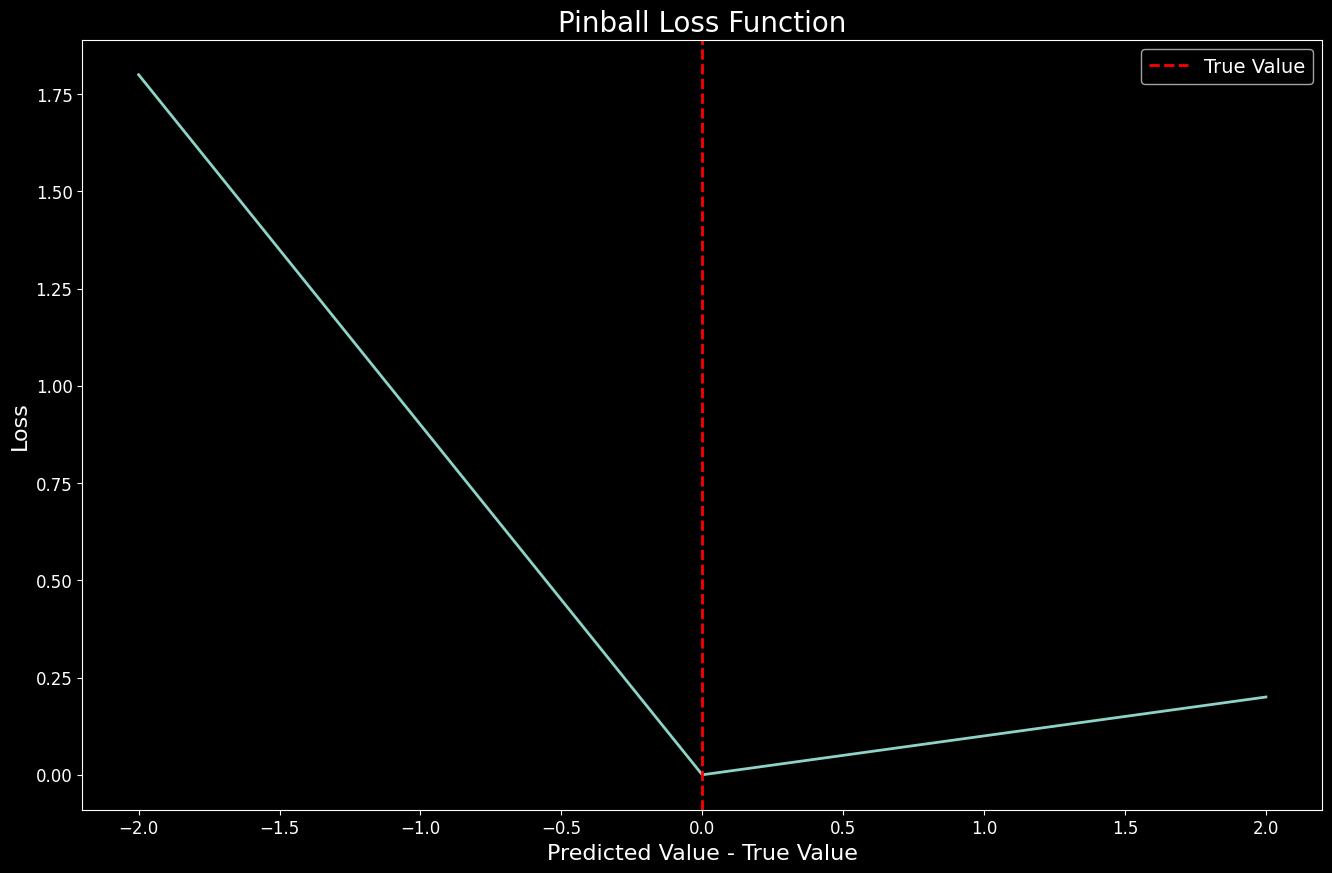

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Pinball Loss Function
def pinball_loss(y_true, y_pred, alpha):
    loss = np.where(y_true >= y_pred,
                    alpha * (y_true - y_pred),
                    (1 - alpha) * (y_pred - y_true))
    return loss


y_true = 0
y_pred = np.linspace(-2, 2, 1000)
alpha = 0.9

loss = pinball_loss(y_true, y_pred, alpha)

plt.figure()
plt.plot(y_pred, loss)
plt.title('Pinball Loss Function')
plt.xlabel('Predicted Value - True Value')
plt.ylabel('Loss')
plt.axvline(x=y_true, color='r', linestyle='--', label='True Value')
plt.legend()


📌 Understanding the Pinball Loss Function:

🎯 What it shows:
- The graph illustrates how the Pinball Loss changes based on our prediction.
- The red dashed line represents the true value (in this case, 0).

📉 Left side of the true value:
- Steeper slope
- Represents underestimation
- Higher penalty for predicting too low

📈 Right side of the true value:
- Gentler slope
- Represents overestimation
- Lower penalty for predicting too high

💡 Key takeaways:
1. The loss is minimal (zero) when our prediction matches the true value.
2. The loss increases as our prediction moves away from the true value in either direction.
3. Underestimating (predicting too low) is penalized more heavily than overestimating.

🧠 Real-world analogy:
Imagine planning a road trip. Running out of gas (underestimating) is worse than having too much gas (overestimating). The Pinball Loss function reflects this by having a steeper slope for underestimation.

🔑 Why it's useful:
This loss function helps create forecasts that balance the risks of under- and over-prediction, which is crucial in many real-world scenarios like inventory management or financial forecasting.

--------------------------
2. 📈 CRPS (Continuous Ranked Probability Score)
- Range: [0, ∞)
- Measures accuracy of full predictive distribution
- Generalizes absolute error to probabilistic forecasts
- Interpretation: Lower CRPS = better forecast
- Advantage: Sensitive to distance, rewards sharp and calibrated forecasts


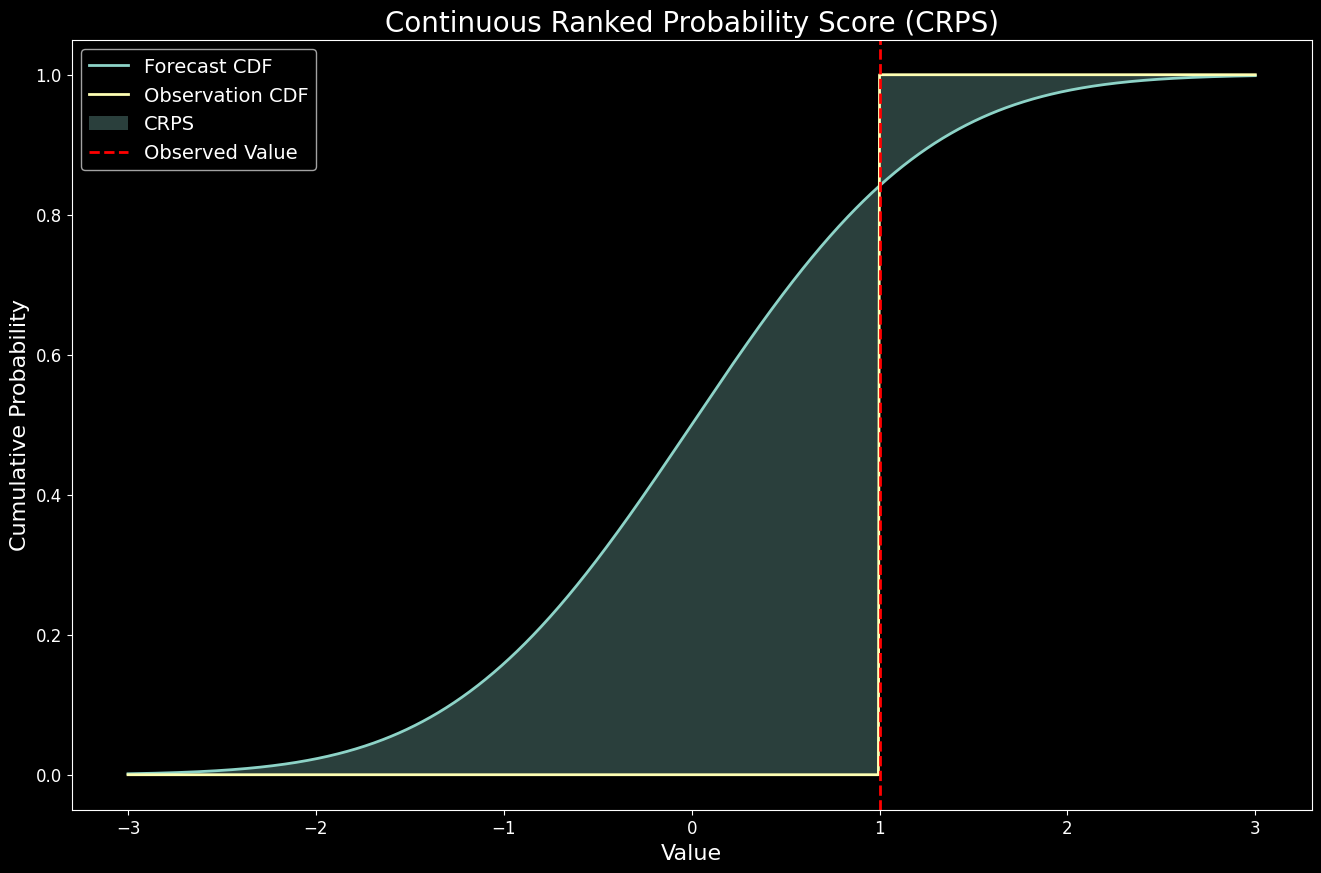

In [40]:
from scipy.special import erf

# CRPS Visualization
x = np.linspace(-3, 3, 1000)
obs = 1.0

# Example forecast CDF (normal distribution)
forecast_cdf = 0.5 * (1 + erf(x / np.sqrt(2)))

# Step function for observation
obs_cdf = np.where(x < obs, 0, 1)

plt.figure()
plt.plot(x, forecast_cdf, label='Forecast CDF')
plt.plot(x, obs_cdf, label='Observation CDF')
plt.fill_between(x, forecast_cdf, obs_cdf, alpha=0.3, label='CRPS')
plt.axvline(x=obs, color='r', linestyle='--', label='Observed Value')
plt.title('Continuous Ranked Probability Score (CRPS)')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.legend()



📊 Understanding the CRPS Plot

🔵 Blue Line: Forecast CDF
- Shows probability of forecasted values
- Smooth S-shape = range of possible outcomes

🟠 Orange Line: Observation CDF
- Actual observed value
- Steps from 0 to 1 at observation point

🔴 Red Dashed Line: Observed Value
- Marks the actual observed value

🔷 Blue Shaded Area: CRPS
- Key focus! Area between blue and orange lines
- Smaller area = better forecast

💡 Interpretation:
- Closer blue line to orange step = better forecast
- Perfect forecast: Blue line matches orange step exactly

🎯 Why CRPS Matters:
- Considers entire probability distribution
- Rewards sharp and well-calibrated forecasts

📉 This Example:
- Forecast looks decent (steep rise near observation)
- Some room for improving sharpness and accuracy

🏆 Goal: Minimize CRPS (smaller shaded area)

Now, let's calculate pinball loss and crps for sales data forecasts

In [30]:
import numpy as np


def calculate_pinball_loss(y_true, y_pred, alpha):
    loss = np.where(y_true >= y_pred,
                    alpha * (y_true - y_pred),
                    (1 - alpha) * (y_pred - y_true))
    return np.mean(loss)

# Extract lower and upper bounds
y_pred_lower = y_pred_ints.iloc[:, 0]
y_pred_upper = y_pred_ints.iloc[:, 1]

# Calculate pinball loss for lower bound (2.5th percentile)
pinball_loss_lower = calculate_pinball_loss(df_test.values, y_pred_lower.values, alpha=0.025)

# Calculate pinball loss for upper bound (97.5th percentile)
pinball_loss_upper = calculate_pinball_loss(df_test.values, y_pred_upper.values, alpha=0.975)

# Average the two pinball losses
pinball_loss_avg = (pinball_loss_lower + pinball_loss_upper) / 2

print(f"Pinball Loss (Lower): {pinball_loss_lower}")
print(f"Pinball Loss (Upper): {pinball_loss_upper}")
print(f"Average Pinball Loss: {pinball_loss_avg}")

Pinball Loss (Lower): 8.328614029400619
Pinball Loss (Upper): 18.242058868025897
Average Pinball Loss: 13.285336448713258


In [131]:
# Extract lower and upper bounds
y_pred_lower = y_pred_quantiles.iloc[:, 0]
y_pred_upper = y_pred_quantiles.iloc[:, -1]

# Calculate pinball loss for lower bound (2.5th percentile)
pinball_loss_lower = calculate_pinball_loss(
    df_test.values, y_pred_lower.values, alpha=0.025)

# Calculate pinball loss for upper bound (97.5th percentile)
pinball_loss_upper = calculate_pinball_loss(
    df_test.values, y_pred_upper.values, alpha=0.975)

# Average the two pinball losses
pinball_loss_avg = (pinball_loss_lower + pinball_loss_upper) / 2

print(f"Pinball Loss (Lower): {pinball_loss_lower}")
print(f"Pinball Loss (Upper): {pinball_loss_upper}")
print(f"Average Pinball Loss: {pinball_loss_avg}")

Pinball Loss (Lower): 8.328614029400619
Pinball Loss (Upper): 18.242058868025897
Average Pinball Loss: 13.285336448713258


In [133]:
from sktime.performance_metrics.forecasting.probabilistic import CRPS

# Create a CRPS instance
crps = CRPS()

# Calculate CRPS
crps_value = crps.evaluate(df_test, y_pred_dist)

crps_value

,passengers
0,47.478065


let's go ahead and evaluate, visually, the forecasted quantiles

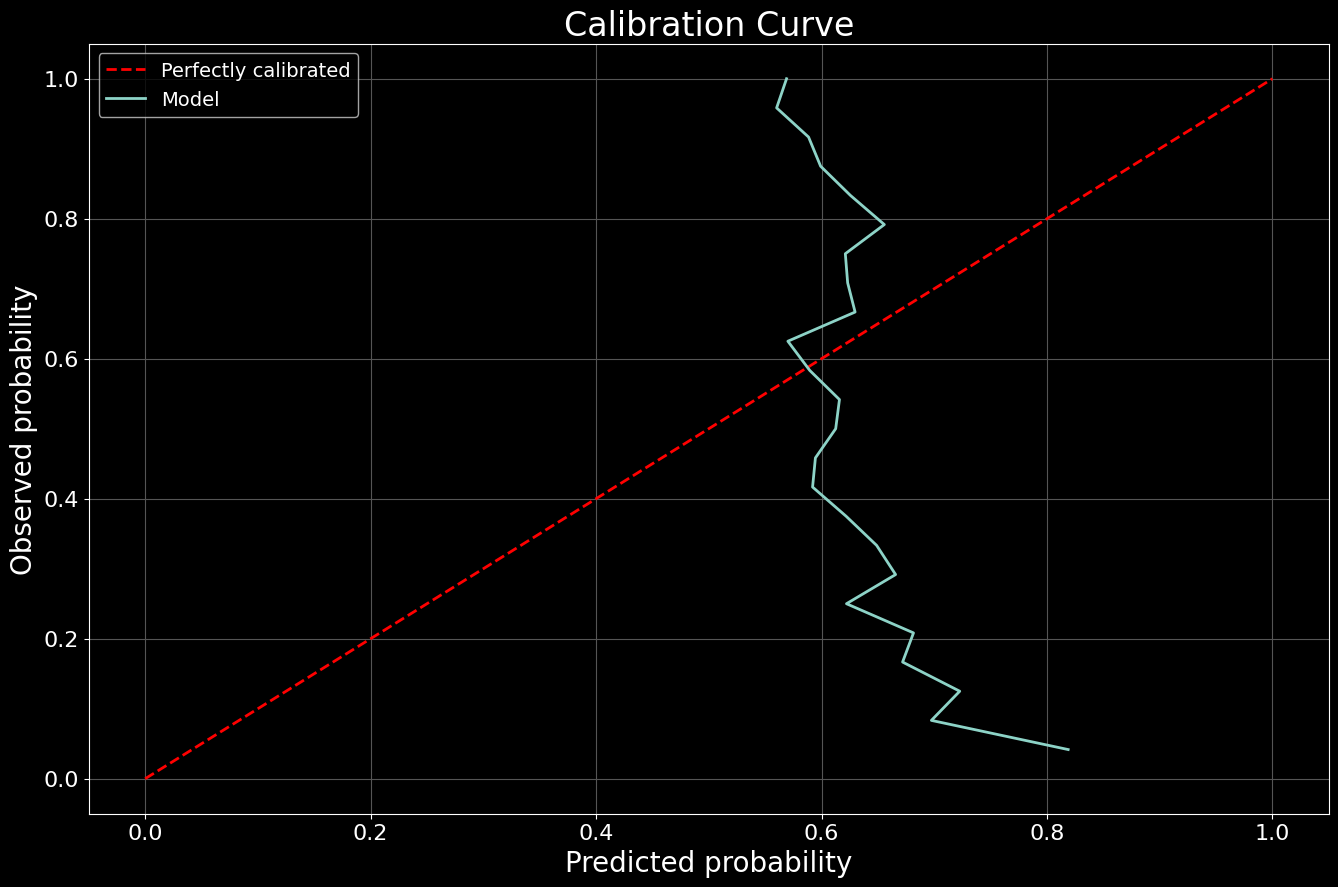

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def calculate_pit(y_true, y_pred_quantiles):
    quantiles = y_pred_quantiles.columns.get_level_values(1).astype(float)
    pit_values = []
    for idx in y_true.index:
        true_value = y_true.loc[idx]
        pred_quantiles = y_pred_quantiles.loc[idx].values
        pit = np.interp(true_value, pred_quantiles, quantiles)
        pit_values.append(pit)
    return np.array(pit_values)


# Calculate PIT values
pit_values = calculate_pit(df_test, y_pred_quantiles)

# Create calibration curve
sorted_pits = np.sort(pit_values)
emp_cdf = np.arange(1, len(sorted_pits) + 1) / len(sorted_pits)

# Plot calibration curve
plt.figure()
plt.plot([0, 1], [0, 1], 'r--', label='Perfectly calibrated')
plt.plot(sorted_pits, emp_cdf, label='Model')
plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

🔍 **Key Observations:**

- Some 2.5% quantile predictions are negative (impossible for passenger counts)
- Prediction intervals are extremely wide, especially for later dates
- Uncertainty increases over time
- True values often near or above 97.5% quantile, especially early on

🤔 **Why the Curve Looks Unusual:**

- Negative lower quantiles and wide intervals skew PIT calculation
- Model might be underestimating passenger counts
- Increasing uncertainty not well-reflected in standard calibration curve

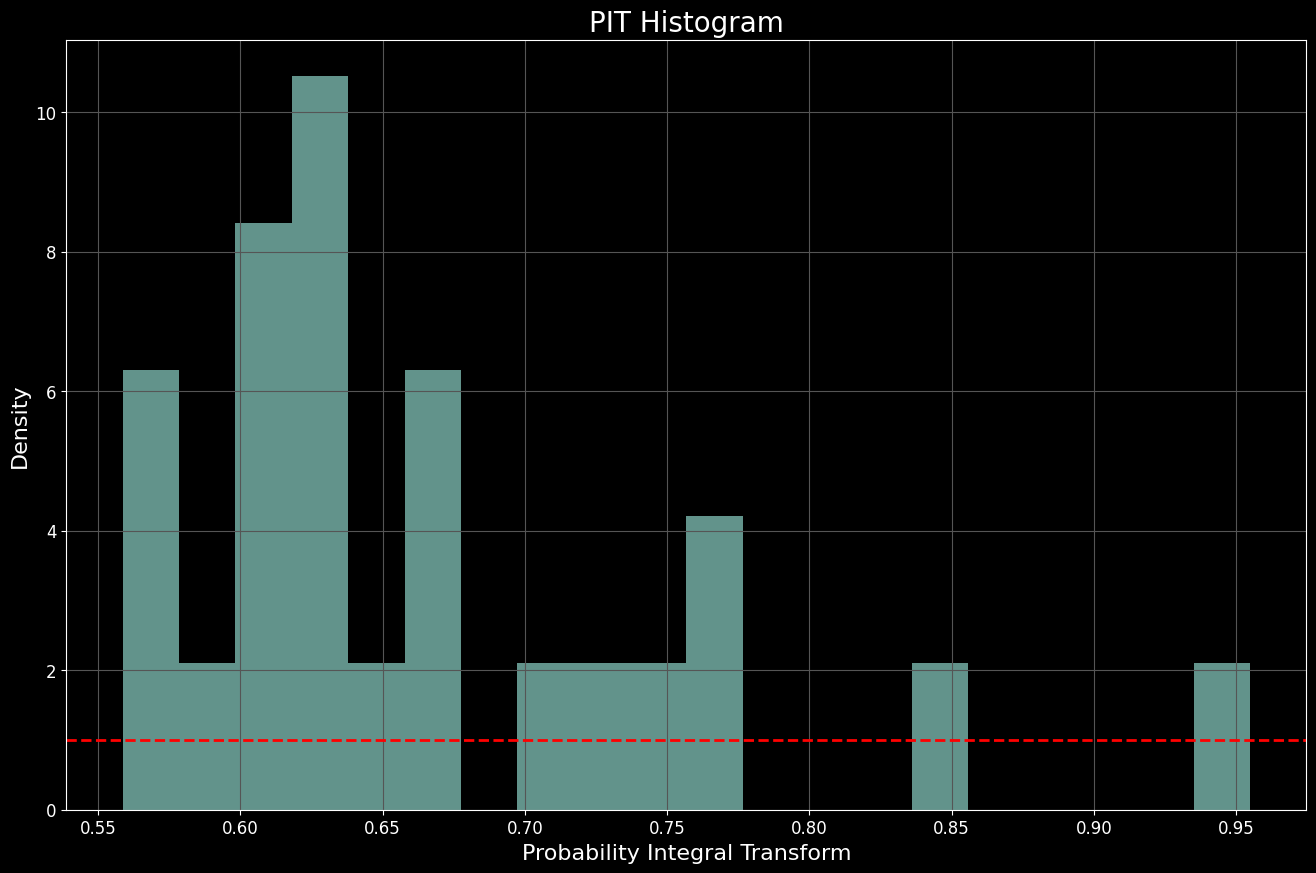

In [180]:

# PIT Histogram
plt.figure()
plt.hist(pit_values, bins=20, density=True, alpha=0.7)
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel('Probability Integral Transform')
plt.ylabel('Densorted_pitssity')
plt.title('PIT Histogram')
plt.grid(True)
plt.show()

📊 *PIT Histogram Analysis*

❌ *Current Issues:*
- Skewed towards 0.55-0.95 range
- Huge peak at 0.60-0.65 (density > 10!)
- No values below 0.55 (yikes!)
- Far from uniform distribution
- Overrepresentation in 0.55-0.65 range
- Underrepresentation in 0.65-0.75 and above 0.80

✅ *Perfect PIT Diagram Checklist:*
- Uniform distribution across 0-1 range
- All bars touch the y=1 line (no higher, no lower)
- No peaks or valleys
- Full coverage from 0 to 1
- Consistent bar heights throughout



💡 **Recommendations:**

1. Revise model to prevent negative predictions (e.g., log-transform)
2. Investigate wide and growing prediction intervals
3. Try alternative models or ensemble methods


🎯 *Key Takeaway:*
Our model's probabilistic forecasts need serious calibration work. It's struggling with lower probabilities and showing systematic overestimation. Time to roll up our sleeves and dig into the model structure!

let's discuss ways to improve forecasts

---
### 3. advanced composition: tuning, pipelines, reduction

composition = constructing "composite" estimators out of multiple "component" estimators

1. **tuning** = automated hyper-parameter fitting, usually via internal evaluation loop
    * special case: grid parameter search and random parameter search tuning
   
2. **reduction** = building estimator type A using estimator type B
    * special case: adding proba forecasting capability to non-proba forecaster

#### 3.1. Tuning and AutoML for Probabilistic Forecasters

🔄 Process: Similar to "ordinary" forecasters
- Use `ForecastingGridSearchCV`, `ForecastingRandomSearchCV`, or `ForecastingOptunaSearchCV`

📊 For Tuning Probabilistic Forecasters:
1. Wrap the probabilistic forecaster to tune
2. Use a probabilistic metric or loss function (e.g., `PinballLoss`, `CRPS`)

⚙️ Internal Evaluation:
- Done using the chosen probabilistic metric
- Via backtesting evaluation

⚠️ Important Note:
- To evaluate the tuned estimator:
  • Use it in `evaluate` function
  • Or use a separate benchmarking workflow
- Avoid using internal metric/loss values for final evaluation
  • This is in-sample evaluation
  • Results will be over-optimistic

💡 Key Takeaway:
Tuning process is familiar, but metric choice and final evaluation require special attention for probabilistic forecasters.

##### Digression: Time Series Cross-Validation

| Method | Description | Pros | Cons |
|--------|-------------|------|------|
| Simple Train-Test Split | • Basic approach<br>• Single split point<br>• Limited evaluation | Simple | Limited evaluation |
| Window-Style CV | • More robust<br>• Multiple train-test sets<br>• Better performance estimate | More reliable | More complex |
| Expanding Window | • Training set grows<br>• Test set fixed size<br>• Retains all historical data | Uses all data | May be slow for large datasets |
| Moving (Sliding) Window | • Fixed-size training window<br>• Slides forward each iteration<br>• Useful for non-stationary data | Adapts to recent trends | May miss long-term patterns |

```gherkin
Simple Train-Test Split:
|-------- Train --------|-Test-|

Expanding Window:
|---- Train 1 ----|-Test-|
|-------- Train 2 --------|-Test-|
|------------ Train 3 ------------|-Test-|

Moving (Sliding) Window:
|---- Train 1 ----|-Test-|
    |---- Train 2 ----|-Test-|
        |---- Train 3 ----|-Test-|

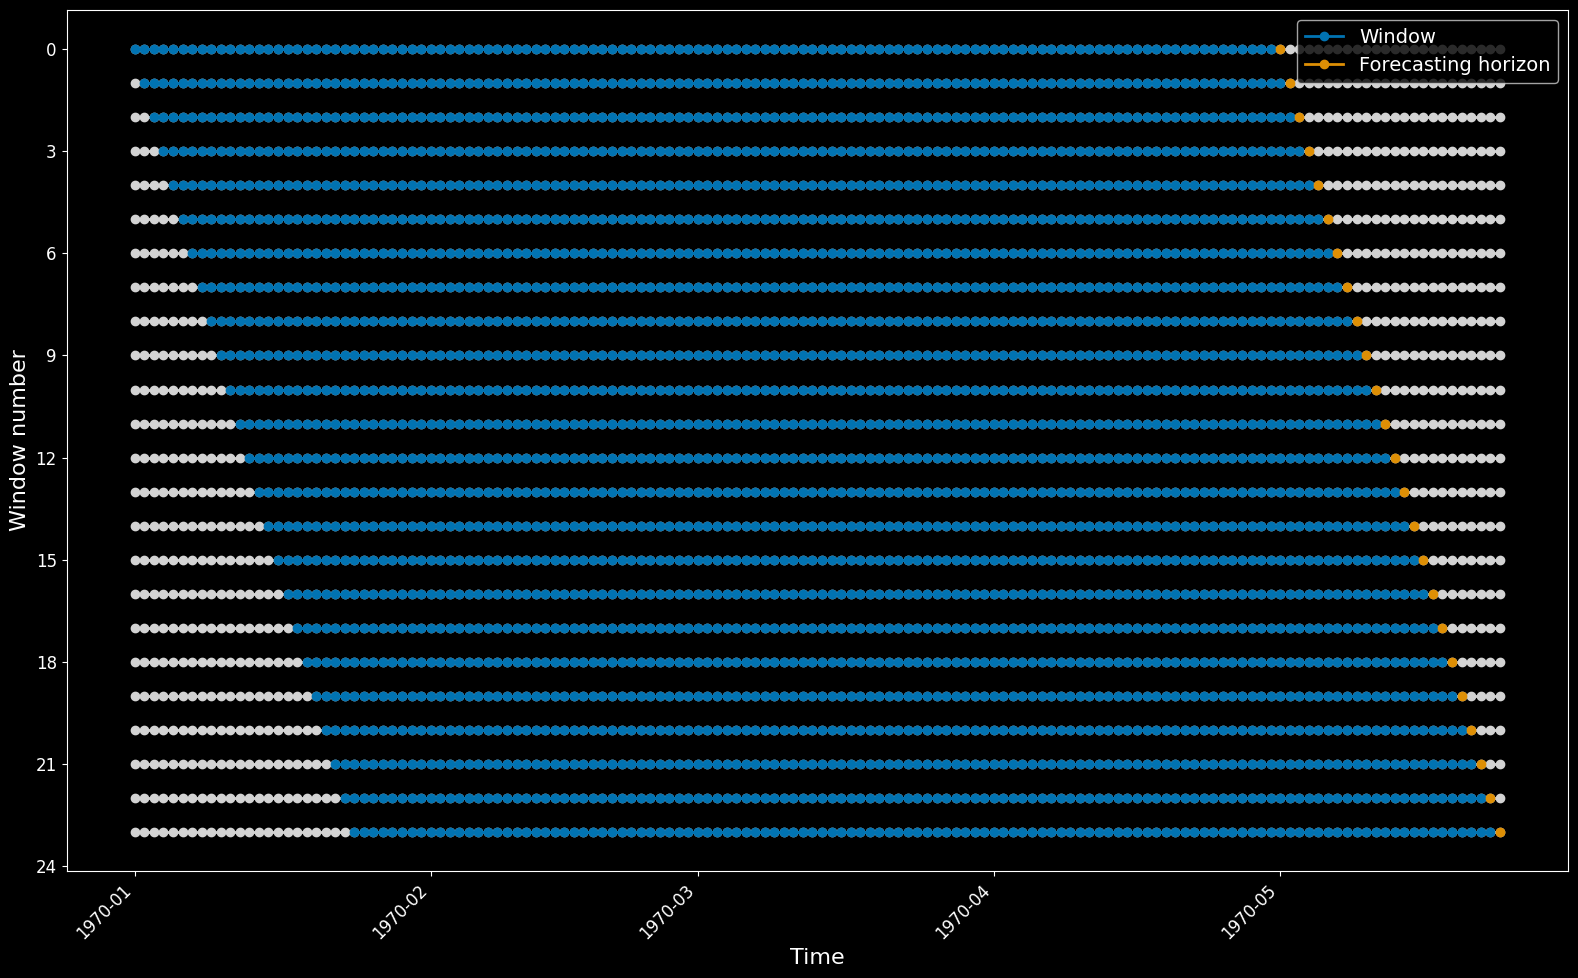

In [194]:
from sktime.utils import plot_windows
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sktime.split import SlidingWindowSplitter

# Set up expanding window cross-validation
# window_length: Start with all data in the training set
# step_length=1: Move forward 1 step at a time
# fh=[1]: Forecast horizon of 1 step
cv = SlidingWindowSplitter(window_length=len(df_train), step_length=1, fh=[1])

# Create the figure and axis objects
fig, ax = plt.subplots()

# Plot the windows
_ = plot_windows(cv, df, ax=ax)

# Customize x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

# Adjust layout and display
plt.tight_layout()
plt.show()

back to tuning .....

In [25]:
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

# step 1: data specification -- already done!

# step 2: specifying forecasting horizon
horizon = len(df_test)
fh = ForecastingHorizon(np.arange(1, horizon + 1))

# step 3: Create a function to build the pipeline
def create_pipeline(lags=1, sp=1, model="additive"): # Default values, will be tuned
    return TransformedTargetForecaster([
        ("differencer", Differencer(lags=lags)),
        ("deseasonalizer", Deseasonalizer(sp=sp)),
        ("detrender", Detrender(model=model)),
        ("model", StatsForecastAutoARIMA(**monthly_params))
    ])


# Create the base forecaster
forecaster = create_pipeline()
# parameter grid to search over
param_grid = {
    "differencer__lags": [1, 2, 3],
    "deseasonalizer__sp": [12, 24],
    "detrender__model": ["additive", "multiplicative"]
    }

# evaluation/backtesting regime for *tuning*
fh_tune = [1]  # fh for tuning regime
cv = SlidingWindowSplitter(window_length=int(len(df_train)*.9), fh=fh_tune)
scoring = PinballLoss()

# construct the composite forecaster with grid search compositor
gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=param_grid, scoring=scoring, strategy="refit"
)

# Fit the grid search (this will perform the tuning)
gscv.fit(df_train)

# Get the best parameters
best_params = gscv.best_params_
print("Best parameters:", best_params)

# Create the final pipeline with the best parameters
best_sp = best_params['deseasonalizer__sp']
best_lags = best_params['differencer__lags']
best_model = best_params['detrender__model']
final_pipe_arima = create_pipeline(sp=best_sp, lags=best_lags, model=best_model)

# Fit the final pipeline on the entire training data
final_pipe_arima.fit(df_train, fh=fh)

Best parameters: {'deseasonalizer__sp': 24, 'detrender__model': 'multiplicative', 'differencer__lags': 1}


TransformedTargetForecaster(steps=[('differencer', Differencer()),
                                   ('deseasonalizer', Deseasonalizer(sp=24)),
                                   ('detrender',
                                    Detrender(model='multiplicative')),
                                   ('model',
                                    StatsForecastAutoARIMA(max_p=3, max_q=3,
                                                           method='mle', sp=12,
                                                           start_P=0, start_Q=0,
                                                           start_p=0,
                                                           start_q=0))])

let's see if this HPO/tuning improved results

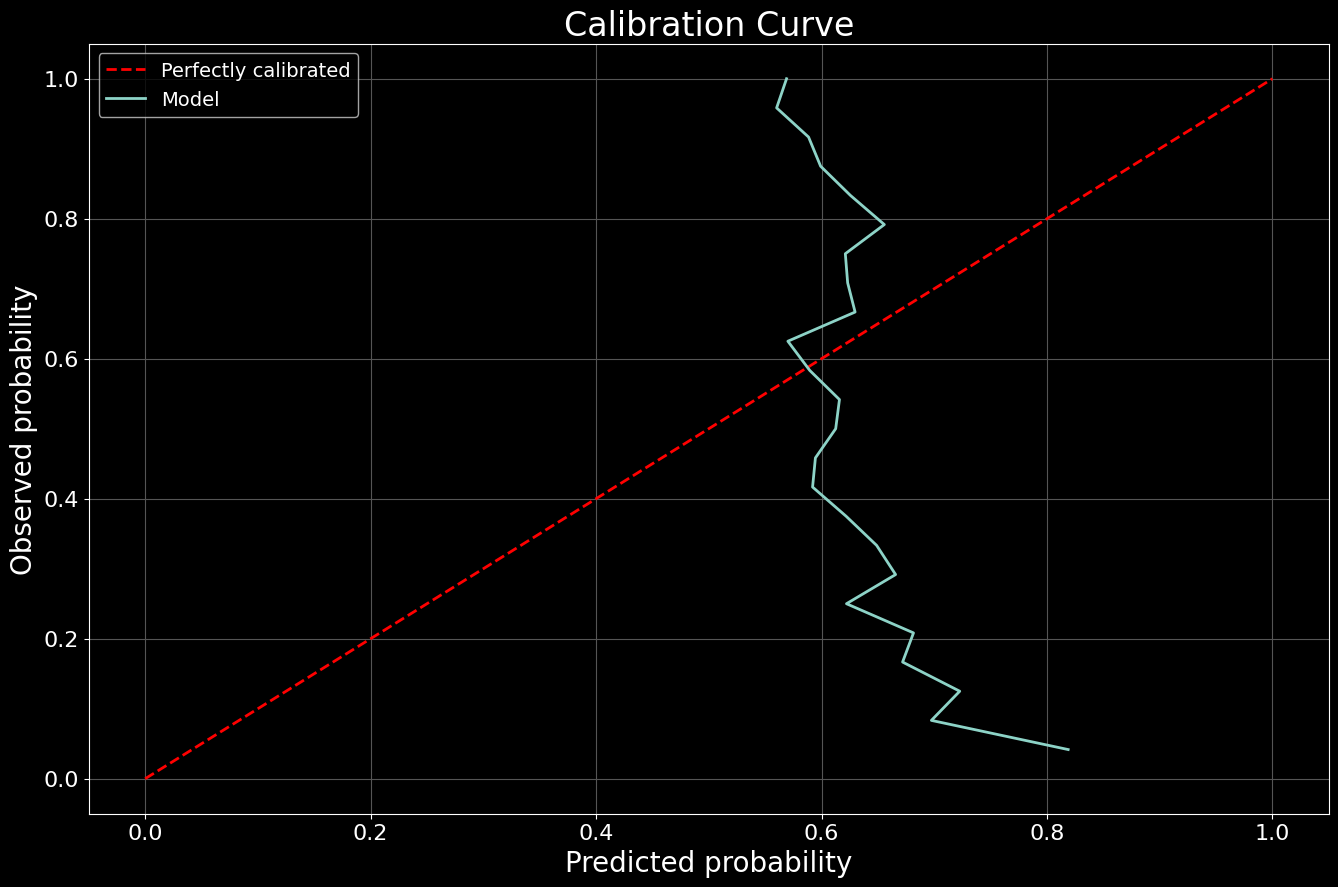

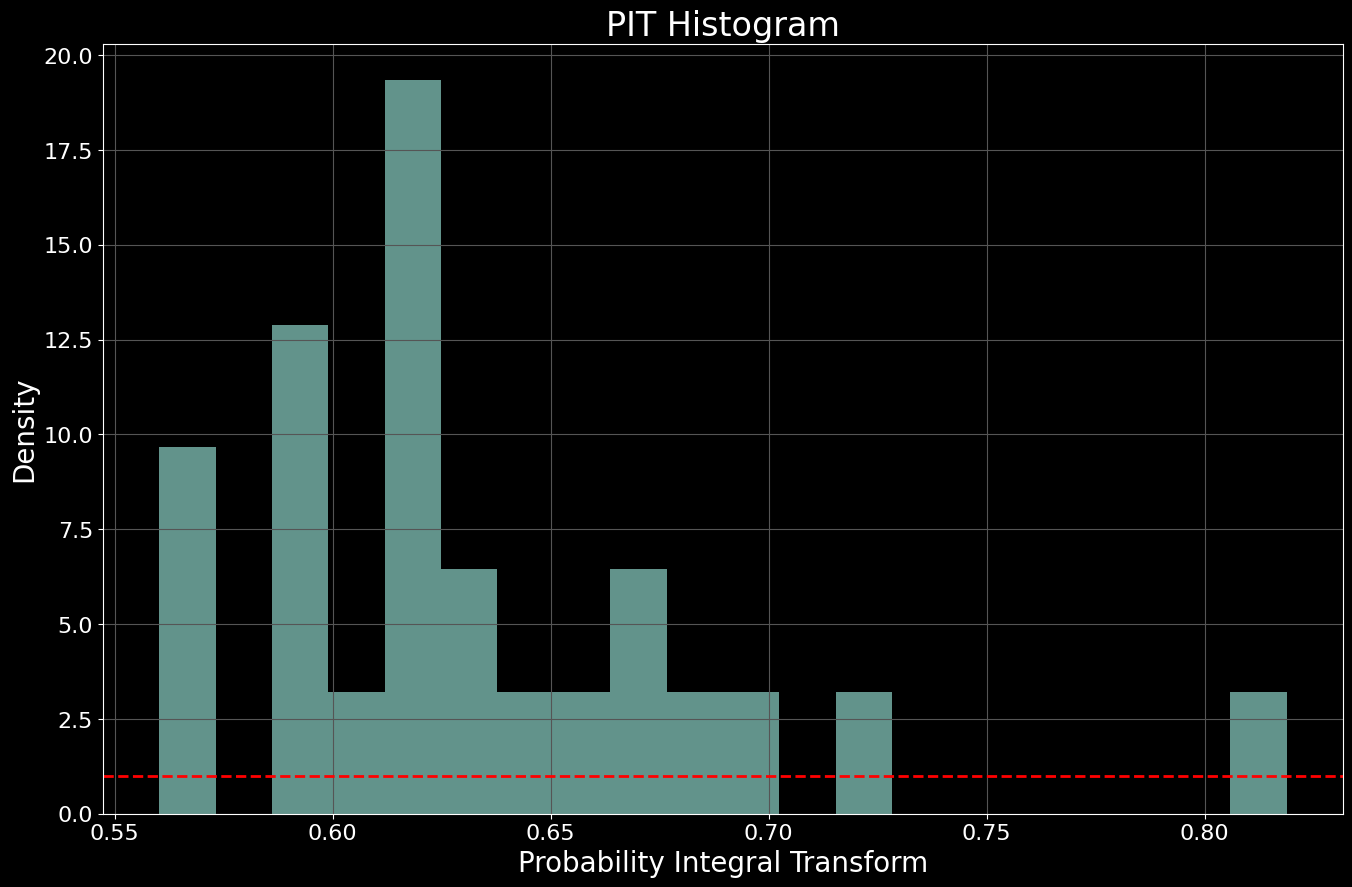

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get the prediction quantiles
y_pred_quantiles = final_pipe_arima.predict_quantiles(
    alpha=[0.025, 0.5, 0.975])

# Calculate PIT values
pit_values = calculate_pit(df_test, y_pred_quantiles)

# Create calibration curve
sorted_pits = np.sort(pit_values)
emp_cdf = np.arange(1, len(sorted_pits) + 1) / len(sorted_pits)

# Plot calibration curve
plt.figure()
plt.plot([0, 1], [0, 1], 'r--', label='Perfectly calibrated')
plt.plot(sorted_pits, emp_cdf, label='Model')
plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

# PIT Histogram
plt.figure()
plt.hist(pit_values, bins=20, density=True, alpha=0.7)
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel('Probability Integral Transform')
plt.ylabel('Density')
plt.title('PIT Histogram')
plt.grid(True)
plt.show()

let's get quantitative. remember, our previous results were:

```gherkin
Pinball Loss (Lower): 8.328614029400619
Pinball Loss (Upper): 18.242058868025897
Average Pinball Loss: 13.285336448713258

In [31]:
# Extract lower and upper bounds
y_pred_lower = y_pred_quantiles.iloc[:, 0]
y_pred_upper = y_pred_quantiles.iloc[:, -1]

# Calculate pinball loss for lower bound (2.5th percentile)
pinball_loss_lower = calculate_pinball_loss(
    df_test.values, y_pred_lower.values, alpha=0.025)

# Calculate pinball loss for upper bound (97.5th percentile)
pinball_loss_upper = calculate_pinball_loss(
    df_test.values, y_pred_upper.values, alpha=0.975)

# Average the two pinball losses
pinball_loss_avg = (pinball_loss_lower + pinball_loss_upper) / 2

print(f"Pinball Loss (Lower): {pinball_loss_lower}")
print(f"Pinball Loss (Upper): {pinball_loss_upper}")
print(f"Average Pinball Loss: {pinball_loss_avg}")

Pinball Loss (Lower): 9.583860190696406
Pinball Loss (Upper): 16.944985014273797
Average Pinball Loss: 13.264422602485102


#### 3.2 (A) Adding probabilistic forecasting to *classical* non-probabilistic forecasters

start with a forecaster that does not produce probabilistic predictions:

In [210]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

my_forecaster = ExponentialSmoothing(sp=7, trend="add")

# does the forecaster support probabilistic predictions?
my_forecaster.get_tag("capability:pred_int")

False

adding probabilistic predictions is possible via reduction wrappers:
```gherkin
Given a time series dataset
When we create 20 bootstrapped copies of the data
And we pass each copy through a forecaster
Then we get 20 separate forecasts

  Time Series Data    Forecaster (Black Box)    Forecasts
  ┌───────────────┐   ┌───────────────────┐   ┌───────────┐
  │ Bootstrap 1   │ → │                   │ → │ Forecast 1│
  │ Bootstrap 2   │ → │                   │ → │ Forecast 2│
  │ ...           │ → │    Forecaster     │ → │ ...       │
  │ Bootstrap 20  │ → │                   │ → │ Forecast20│
  └───────────────┘   └───────────────────┘   └───────────┘

In [211]:
from sktime.transformations.bootstrap import TSBootstrapAdapter
from sktime.forecasting.compose import BaggingForecaster
from sktime.transformations.series.detrend import Detrender , Deseasonalizer
from tsbootstrap.block_bootstrap import MovingBlockBootstrap
from tsbootstrap.bootstrap import BlockResidualBootstrap


# Initialize the bootstrapper with custom settings
adapter = TSBootstrapAdapter(BlockResidualBootstrap(block_bootstrap=MovingBlockBootstrap(n_bootstraps=20)))
# Create a BaggingForecaster using the bootstrap adapter and a SARIMA model
my_forecaster_with_proba = Deseasonalizer(
    sp=7, model="multiplicative") * Detrender() * BaggingForecaster(adapter, my_forecaster)

# does the forecaster support probabilistic predictions?
my_forecaster_with_proba.get_tag("capability:pred_int")

True

the composite can now be used like any probabilistic forecaster:

In [239]:
import pandas as pd

horizon = len(df_test)
fh = ForecastingHorizon(np.arange(1, horizon + 1), is_relative=True)

#fh = ForecastingHorizon(pd.date_range(start='1959-01-31', periods=24, freq='M'))

my_forecaster_with_proba.fit(df_train.values, fh=fh)
my_forecaster_with_proba.predict_interval(coverage=0.95)

0            
           0.95            
          lower       upper
120  328.612207  361.464448
121  330.031598  364.520571
122  332.971223  369.272761
123  329.331204  366.722071
124  332.628219  371.891712
125  334.107480  375.047782
126  332.129268  374.317731
127  330.732855  374.225519
128  332.159445  377.324956
129  335.116047  382.179309
130  331.450630  379.475789
131  334.766898  384.761278
132  336.253699  387.962720
133  334.260823  387.144430
134  332.853504  386.986589
135  334.287292  390.129341
136  337.260871  395.085856
137  333.570057  392.229507
138  336.905577  397.630845
139  338.399917  400.877657
140  336.392378  399.971129
141  334.974153  399.747659
142  336.415139  402.933727
143  339.405696  407.992404

wrappers of this type:

* `NaiveVariance` (a "baseline")
* `SquaringResiduals`
* `ConformalIntervals`
* `EnbPIForecaster`
* `BaggingForecaster`, usable with
    * `STLBootstrapTransformer`
    * `MovingBlockBootstrapTransformer`
    * `SplitterBootstrapTransformer`
    * `TSBootstrapAdapter` to use any `tsbootstrap` bootstrap!

#### 3.2 (B) Adding probabilistic forecasting to *ML* non-probabilistic forecasters


In [43]:
from sktime.transformations.series.summarize import WindowSummarizer

kwargs = {
    "lag_feature": {
        "lag": np.arange(36 + 1),
    }
}
transformer = WindowSummarizer(**kwargs)
X_train = transformer.fit_transform(df_train)
X_test = transformer.transform(df_test)

# drop rows with nans
X_train = X_train.dropna()
X_test = X_test.dropna()

In [44]:
X_train

,passengers_lag_0,passengers_lag_1,passengers_lag_2,passengers_lag_3,passengers_lag_4,passengers_lag_5,passengers_lag_6,passengers_lag_7,passengers_lag_8,passengers_lag_9,...,passengers_lag_27,passengers_lag_28,passengers_lag_29,passengers_lag_30,passengers_lag_31,passengers_lag_32,passengers_lag_33,passengers_lag_34,passengers_lag_35,passengers_lag_36
Period,,,,,,,,,,,,,,,,,,,,,
1952-01-01,171.0,166.0,146.0,162.0,184.0,199.0,199.0,178.0,172.0,163.0,...,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0
1952-02-01,180.0,171.0,166.0,146.0,162.0,184.0,199.0,199.0,178.0,172.0,...,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0
1952-03-01,193.0,180.0,171.0,166.0,146.0,162.0,184.0,199.0,199.0,178.0,...,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0
1952-04-01,181.0,193.0,180.0,171.0,166.0,146.0,162.0,184.0,199.0,199.0,...,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0
1952-05-01,183.0,181.0,193.0,180.0,171.0,166.0,146.0,162.0,184.0,199.0,...,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1958-08-01,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0,336.0,305.0,...,318.0,313.0,317.0,277.0,284.0,278.0,237.0,274.0,312.0,347.0
1958-09-01,404.0,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0,336.0,...,374.0,318.0,313.0,317.0,277.0,284.0,278.0,237.0,274.0,312.0
1958-10-01,359.0,404.0,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0,...,413.0,374.0,318.0,313.0,317.0,277.0,284.0,278.0,237.0,274.0


In [45]:
# separate the target variable
y_train, y_test = X_train['passengers_lag_0'], X_test['passengers_lag_0']
X_train.drop(columns=['passengers_lag_0'], inplace=True)
X_test.drop(columns=['passengers_lag_0'], inplace=True)

In [46]:
y_train

Period
1952-01-01    171.0
1952-02-01    180.0
1952-03-01    193.0
1952-04-01    181.0
1952-05-01    183.0
              ...  
1958-08-01    505.0
1958-09-01    404.0
1958-10-01    359.0
1958-11-01    310.0
1958-12-01    337.0
Freq: MS, Name: passengers_lag_0, Length: 84, dtype: float64

generate date-time features

In [47]:
from sktime.transformations.series.date import DateTimeFeatures

# Returns columns ‘y’, ‘year’, ‘quarter_of_year’, ‘month_of_year’, ‘month_of_quarter’

transformer = DateTimeFeatures(ts_freq="M", feature_scope="comprehensive")
X_train_time = transformer.fit_transform(X_train)
X_test_time = transformer.transform(X_test)

In [48]:
X_train_time

,year,quarter_of_year,month_of_year,month_of_quarter
Period,,,,
1952-01-01,1952,1,1,1
1952-02-01,1952,1,2,2
1952-03-01,1952,1,3,3
1952-04-01,1952,2,4,1
1952-05-01,1952,2,5,2
...,...,...,...,...
1958-08-01,1958,3,8,2
1958-09-01,1958,3,9,3
1958-10-01,1958,4,10,1


generate features using `tsfresh`

In [55]:
import warnings
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
import pandas as pd

warnings.filterwarnings("ignore")

# Initialize TSFreshFeatureExtractor
extractor = TSFreshFeatureExtractor(
    default_fc_parameters="minimal", disable_progressbar=True)

# Function to extract features for a single row
def extract_features_for_row(row):
    # Convert row to a format TSFreshFeatureExtractor expects
    series = pd.DataFrame({'passengers': row.values, 'time': range(len(row))})
    series = series.set_index('time')

    # Create a panel dataset as expected by TSFreshFeatureExtractor
    panel = pd.DataFrame({
        #'id': [0] * len(series),
        #'time': series.index,
        'passengers': series['passengers']
    })

    # Extract features
    features = extractor.fit_transform(panel)

    return features.iloc[0]  # Return as a series


# Apply feature extraction to X_train and X_test
X_train_tsfresh = X_train.apply(extract_features_for_row, axis=1)
X_test_tsfresh = X_test.apply(extract_features_for_row, axis=1)

# Concatenate the features with the original data
#X_train_concat = pd.concat([X_train, X_train_tsfresh], axis=1)
#X_test_concat = pd.concat([X_test, X_test_tsfresh], axis=1)

let's go ahead and look at the newly generated features

In [56]:
X_train_tsfresh

,passengers__sum_values,passengers__median,passengers__mean,passengers__length,passengers__standard_deviation,passengers__variance,passengers__root_mean_square,passengers__maximum,passengers__absolute_maximum,passengers__minimum
Period,,,,,,,,,,
1952-01-01,5238.0,143.0,145.500000,36.0,24.595054,604.916667,147.564110,199.0,199.0,104.0
1952-02-01,5297.0,145.5,147.138889,36.0,24.271786,589.119599,149.127369,199.0,199.0,104.0
1952-03-01,5359.0,147.0,148.861111,36.0,24.342638,592.564043,150.838306,199.0,199.0,104.0
1952-04-01,5420.0,148.0,150.555556,36.0,25.217327,635.913580,152.652838,199.0,199.0,104.0
1952-05-01,5472.0,148.5,152.000000,36.0,25.429641,646.666667,154.112513,199.0,199.0,104.0
...,...,...,...,...,...,...,...,...,...,...
1958-08-01,12465.0,343.5,346.250000,36.0,58.933284,3473.131944,351.229547,491.0,491.0,237.0
1958-09-01,12623.0,343.5,350.638889,36.0,64.450736,4153.897377,356.513012,505.0,505.0,237.0
1958-10-01,12715.0,347.5,353.194444,36.0,64.691498,4184.989969,359.070057,505.0,505.0,237.0


In [57]:
from pprint import pprint
pprint(list(X_train_tsfresh))

['passengers__sum_values',
 'passengers__median',
 'passengers__mean',
 'passengers__length',
 'passengers__standard_deviation',
 'passengers__variance',
 'passengers__root_mean_square',
 'passengers__maximum',
 'passengers__absolute_maximum',
 'passengers__minimum']


In [65]:
df_train

,passengers
Period,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1958-08-01,505.0
1958-09-01,404.0
1958-10-01,359.0


In [100]:
from sktime.regression.compose import RegressorPipeline
from sktime.forecasting.compose import make_reduction
from xgboost import XGBRegressor
from sktime.transformations.series.date import DateTimeFeatures
from sktime.regression.distance_based import KNeighborsTimeSeriesRegressor
from sktime.transformations.bootstrap import TSBootstrapAdapter
from tsbootstrap.block_bootstrap import MovingBlockBootstrap
from tsbootstrap.bootstrap import BlockResidualBootstrap
from sktime.forecasting.compose import BaggingForecaster



horizon = len(df_test)
fh = ForecastingHorizon(np.arange(1, horizon + 1))

# XGBRegressor(objective='reg:absoluteerror', random_state=42)#, n_estimators=500, max_depth=10)
# 
regressor = KNeighborsTimeSeriesRegressor(n_neighbors=2)

# Initialize TSFreshFeatureExtractor
extractor = TSFreshFeatureExtractor(
    default_fc_parameters="minimal", disable_progressbar=True)

# Initialize DateTimeFeatures
transformer_dt = DateTimeFeatures(ts_freq="M", feature_scope="comprehensive")


regressor_pipeline = RegressorPipeline(
    regressor, [transformer_dt]
)

# Initialize the bootstrapper with custom settings
adapter = TSBootstrapAdapter(BlockResidualBootstrap(
    block_bootstrap=MovingBlockBootstrap(n_bootstraps=20)))

forecaster = make_reduction(regressor, window_length=36, strategy="recursive", windows_identical=False) #* extractor
forecaster_with_proba = BaggingForecaster(adapter, forecaster)

forecaster_with_proba.fit(df_train, fh=fh)

BaggingForecaster(bootstrap_transformer=TSBootstrapAdapter(bootstrap=BlockResidualBootstrap(block_bootstrap=MovingBlockBootstrap(n_bootstraps=20))),
                  forecaster=RecursiveTimeSeriesRegressionForecaster(estimator=KNeighborsTimeSeriesRegressor(n_neighbors=2),
                                                                     window_length=36))

In [78]:
y_pred_quantiles = forecaster_with_proba.predict_quantiles(alpha=[0.025, 0.5, 0.975])
pd.concat([y_pred_quantiles, df_test], axis=1)

,"(passengers, 0.025)","(passengers, 0.5)","(passengers, 0.975)",passengers
Period,,,,
1959-01-01,323.500000,360.263370,360.263370,360.0
1959-02-01,323.500000,360.263370,360.263370,342.0
1959-03-01,323.500000,360.263370,360.263370,406.0
1959-04-01,323.500000,360.263370,389.304351,396.0
1959-05-01,323.500000,360.263370,372.170173,420.0
1959-06-01,323.500000,360.263370,465.023257,472.0
1959-07-01,332.375316,420.403559,469.042245,548.0
1959-08-01,337.266614,451.741138,503.039001,559.0
1959-09-01,337.266614,442.718906,478.747388,463.0


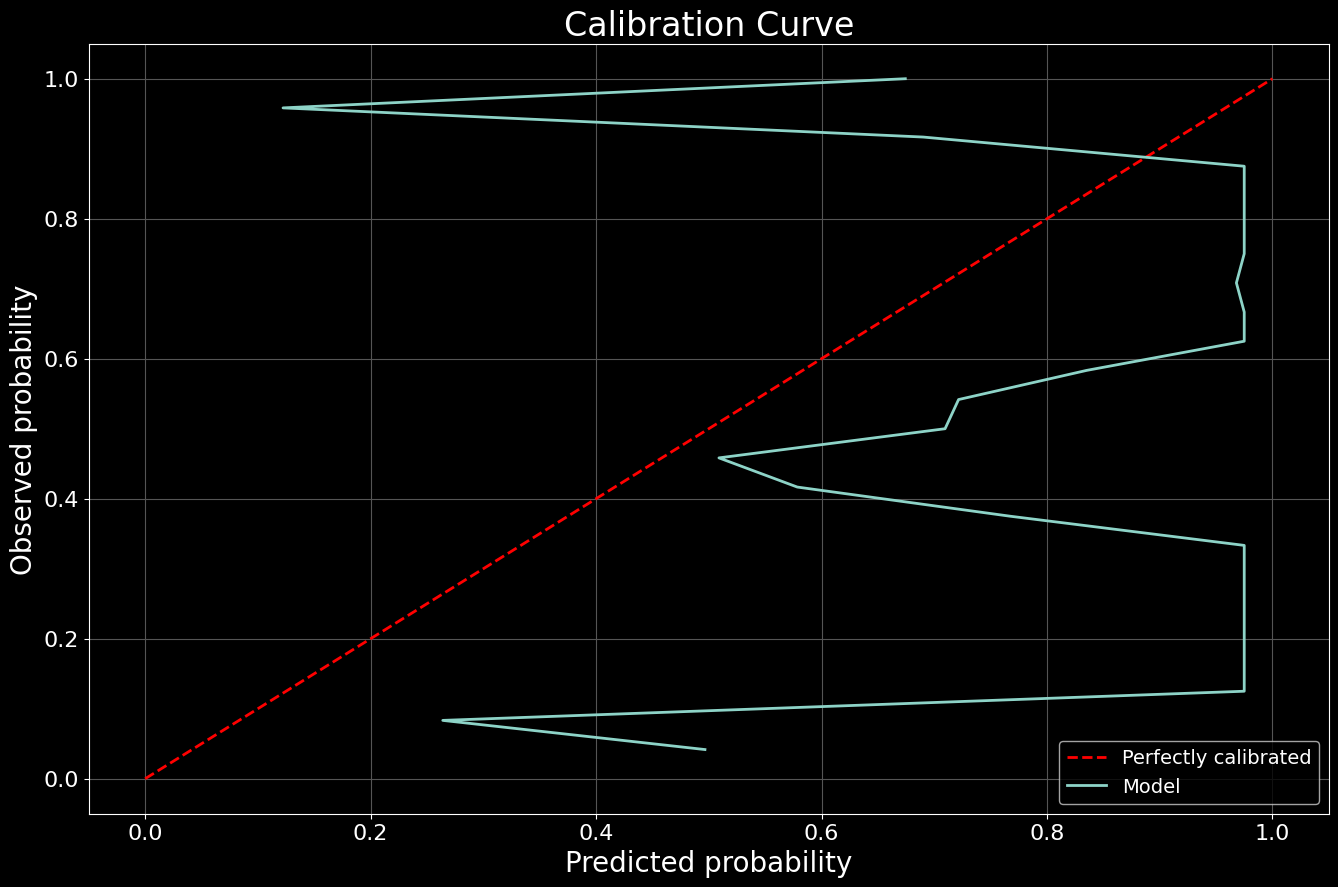

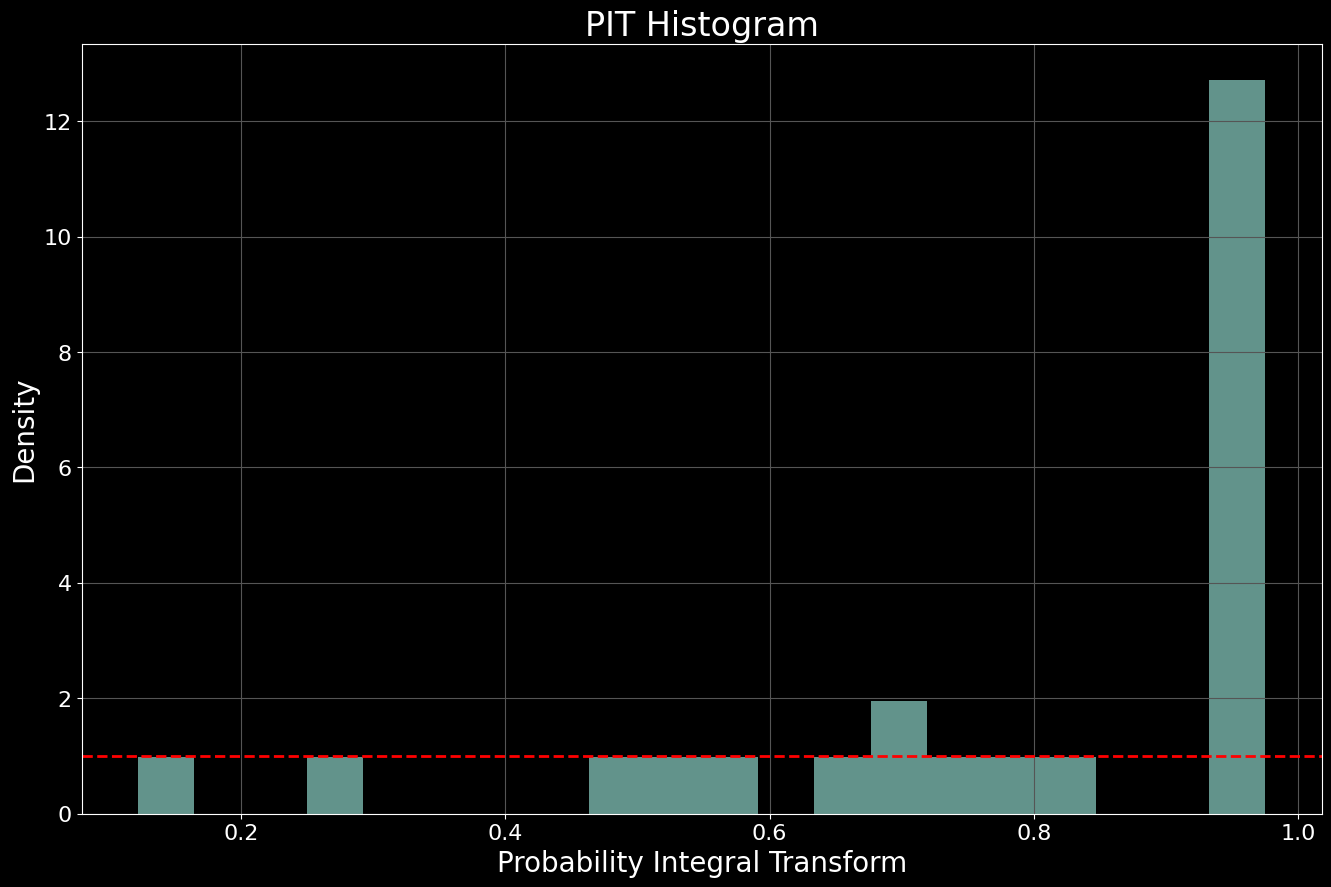

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate PIT values
pit_values = calculate_pit(df_test, y_pred_quantiles)

# Create calibration curve
sorted_pits = np.sort(pit_values)
emp_cdf = np.arange(1, len(sorted_pits) + 1) / len(sorted_pits)

# Plot calibration curve
plt.figure()
plt.plot([0, 1], [0, 1], 'r--', label='Perfectly calibrated')
plt.plot(sorted_pits, emp_cdf, label='Model')
plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


# PIT Histogram
plt.figure()
plt.hist(pit_values, bins=20, density=True, alpha=0.7)
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel('Probability Integral Transform')
plt.ylabel('Density')
plt.title('PIT Histogram')
plt.grid(True)
plt.show()

In [80]:
# Extract lower and upper bounds
y_pred_lower = y_pred_quantiles.iloc[:, 0]
y_pred_upper = y_pred_quantiles.iloc[:, -1]

# Calculate pinball loss for lower bound (2.5th percentile)
pinball_loss_lower = calculate_pinball_loss(
    df_test.values, y_pred_lower.values, alpha=0.025)

# Calculate pinball loss for upper bound (97.5th percentile)
pinball_loss_upper = calculate_pinball_loss(
    df_test.values, y_pred_upper.values, alpha=0.975)

# Average the two pinball losses
pinball_loss_avg = (pinball_loss_lower + pinball_loss_upper) / 2

print(f"Pinball Loss (Lower): {pinball_loss_lower}")
print(f"Pinball Loss (Upper): {pinball_loss_upper}")
print(f"Average Pinball Loss: {pinball_loss_avg}")

Pinball Loss (Lower): 3.36195267798592
Pinball Loss (Upper): 40.15960261775262
Average Pinball Loss: 21.76077764786927


.... fine-tune the above and see if that improves results!!

### Forecasting using CHRONOS


import necessary libraries

In [82]:
import torch  # PyTorch to convert values ino torch tensors.
from chronos import ChronosPipeline

choose model and initialize pipeline.

- 5 models available: `tiny`, `mini`, `small`, `base` and `large` with increasing size and number of parameters.
- we choose `mini` for faster response.
- `device_map` can be chosen appropriately as `cpu` , `auto`, `cuda` etc..

In [83]:
# initialize CHRONOS pipeline 
pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-mini",
                                           device_map="cpu",
                                           torch_dtype=torch.bfloat16)

In [84]:
to_predict = torch.tensor(df_train['passengers'])  # variable for training and predict
horizon = len(df_test)  # forecasting steps

let's go ahead and forecast

In [85]:
chronos_forecast = pipeline.predict(to_predict, horizon)

visualize

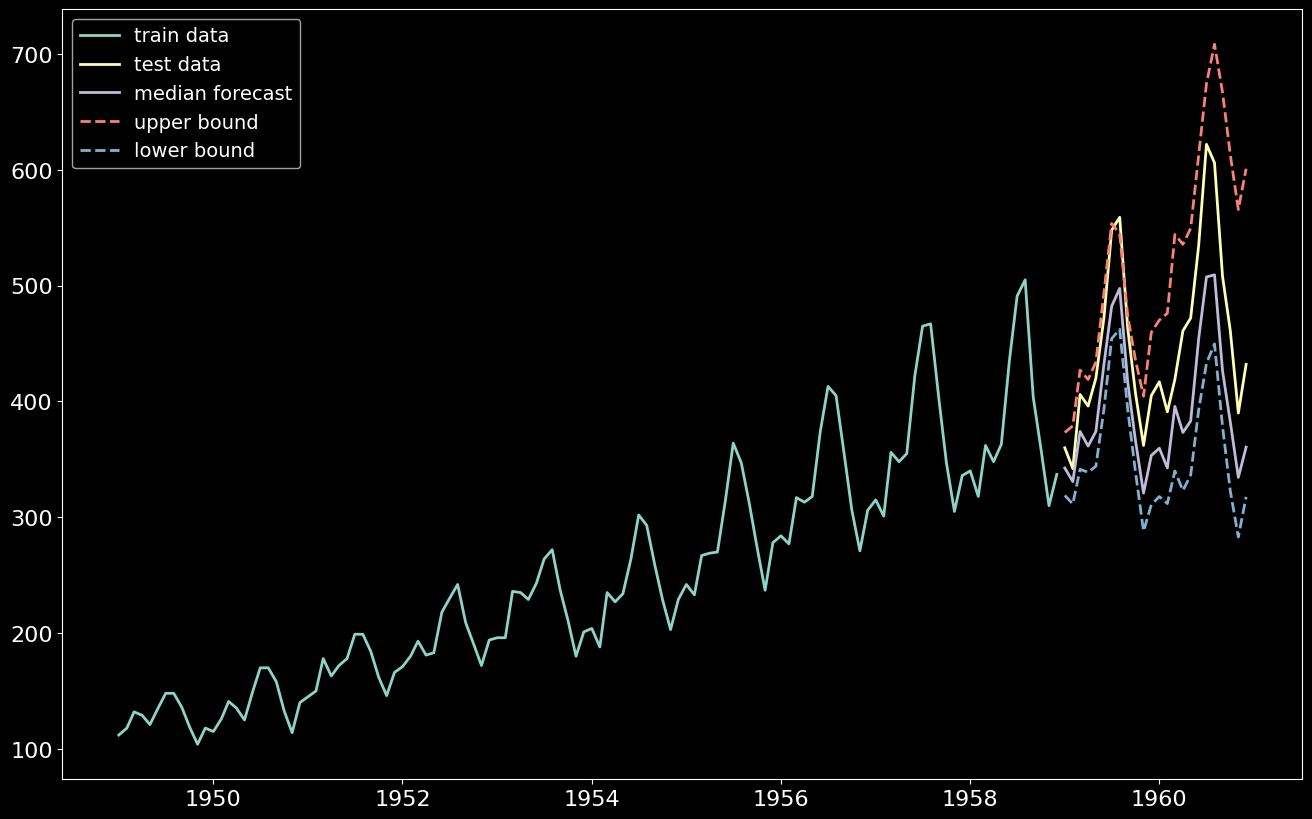

In [95]:
import numpy as np

# the predicted values are in the form of a dense tensor.
chronos_lower, chronos_median, chronos_upper = np.quantile(
    chronos_forecast[0].numpy(), [0.025, 0.5, 0.975], axis=0)

#plot the forecat
plt.subplots()
plt.plot(df_train, label='train data')
plt.plot(df_test, label='test data')
plt.plot(df_test.index, chronos_median, label='median forecast')
plt.plot(df_test.index, chronos_upper, label='upper bound', linestyle='--')
plt.plot(df_test.index, chronos_lower, label='lower bound', linestyle='--')
plt.legend()

In [96]:
# collate the results. create a multi-level column index for the quantiles
y_pred_quantiles_chronos = pd.DataFrame(
    np.vstack([chronos_lower, chronos_median, chronos_upper]).T,
    index=df_test.index,
    columns=pd.MultiIndex.from_product([["passengers"], [0.025, 0.050, 0.975]])
)
y_pred_quantiles_chronos

passengers                        
                 0.025       0.050       0.975
Period                                        
1959-01-01  318.833498  342.540929  373.189329
1959-02-01  311.531961  330.822435  378.958449
1959-03-01  341.414151  374.090751  427.049391
1959-04-01  338.845096  361.470834  418.936588
1959-05-01  344.073348  374.090751  433.945275
1959-06-01  393.020656  431.781860  493.349071
1959-07-01  454.227313  482.261587  553.699390
1959-08-01  462.385188  497.585772  544.549950
1959-09-01  393.020656  416.457675  473.743129
1959-10-01  338.935239  365.977948  435.703048
1959-11-01  288.004814  320.906771  404.513797
1959-12-01  310.765752  353.358030  459.680921
1960-01-01  317.887004  359.667989  470.227580
1960-02-01  311.802388  342.540929  476.176970
1960-03-01  339.926818  395.724924  544.144313
1960-04-01  323.115256  373.189329  535.670940
1960-05-01  336.411269  383.104993  549.462707
1960-06-01  392.930514  454.317455  612.922920
1960-07-01  432.998794  507.501421  674.445074
1960-08-01  449.675128  509.304266  708.383665
1960-09-01  378.327452  426.373324  666.828050
1960-10-01  322.619489  382.203570  612.922917
1960-11-01  282.956834  334.428125  565.733413
1960-12-01  317.616578  360.569412  600.933999

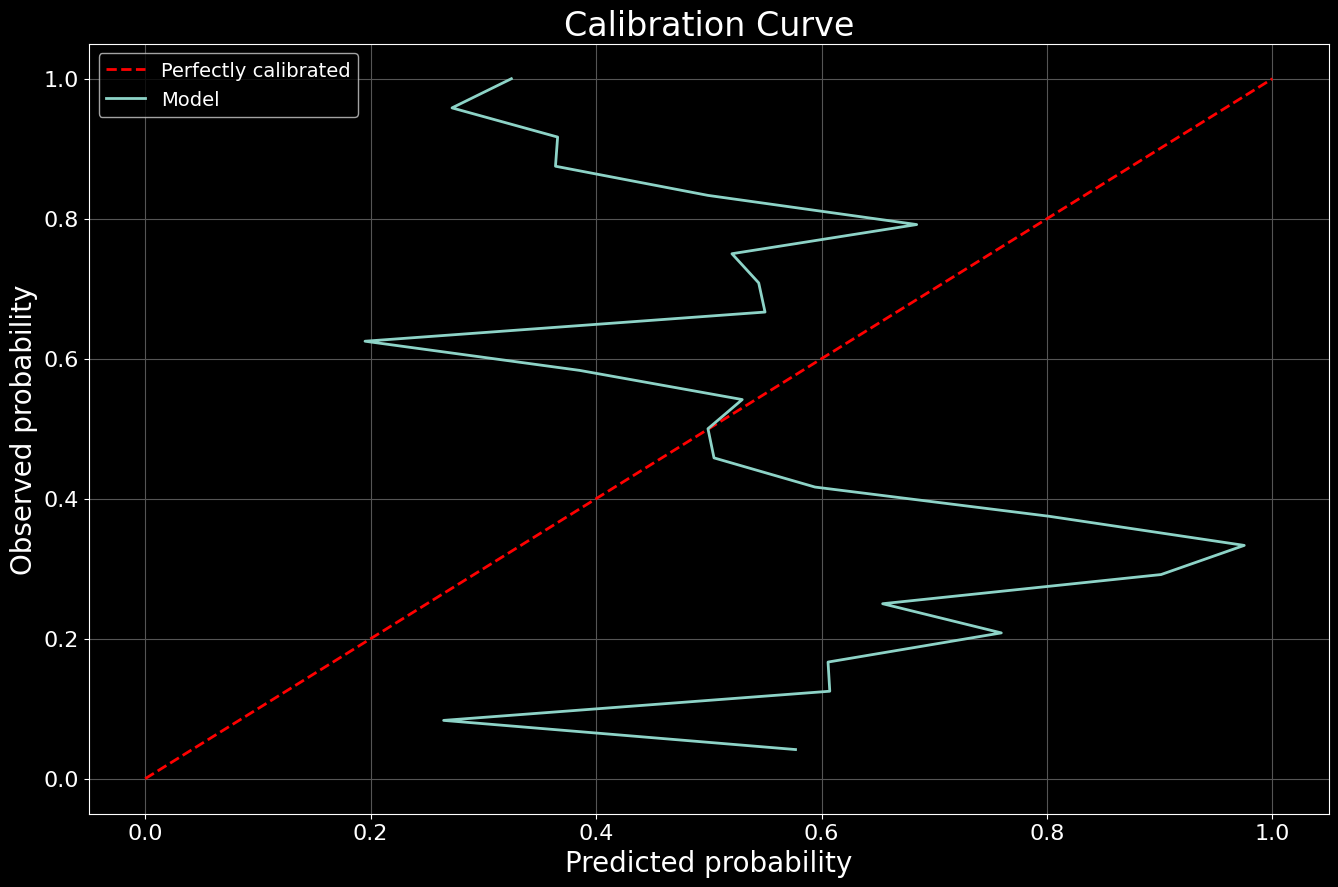

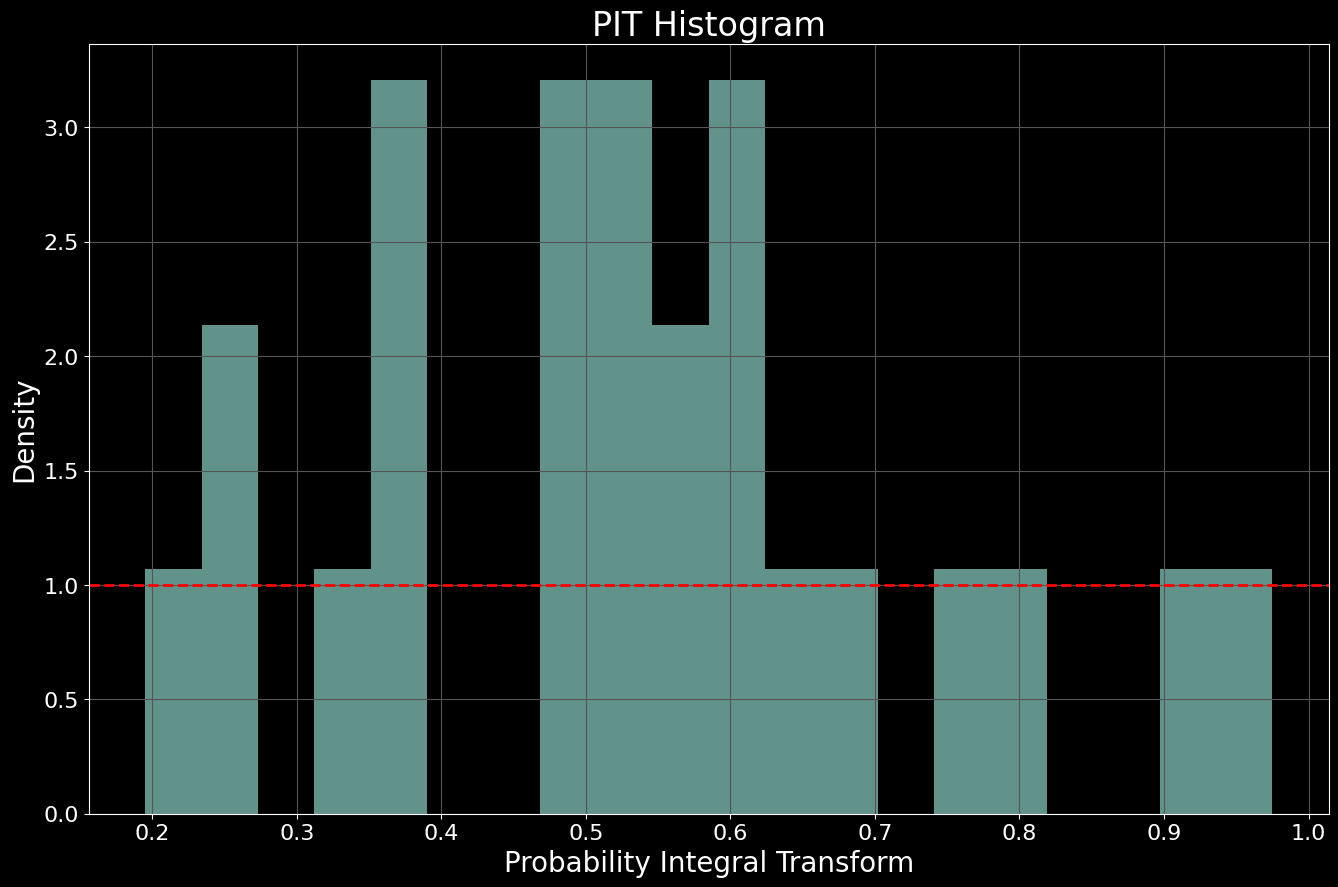

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate PIT values
pit_values = calculate_pit(df_test, y_pred_quantiles_chronos)

# Create calibration curveimport pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate PIT values
pit_values = calculate_pit(df_test, y_pred_quantiles_chronos)

# Create calibration curve
sorted_pits = np.sort(pit_values)
emp_cdf = np.arange(1, len(sorted_pits) + 1) / len(sorted_pits)

# Plot calibration curve
plt.figure()
plt.plot([0, 1], [0, 1], 'r--', label='Perfectly calibrated')
plt.plot(sorted_pits, emp_cdf, label='Model')
plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


# PIT Histogram
plt.figure()
plt.hist(pit_values, bins=20, density=True, alpha=0.7)
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel('Probability Integral Transform')
plt.ylabel('Density')
plt.title('PIT Histogram')
plt.grid(True)
plt.show()
sorted_pits = np.sort(pit_values)
emp_cdf = np.arange(1, len(sorted_pits) + 1) / len(sorted_pits)


let's get the pinball loss values

In [98]:
# Extract lower and upper bounds
y_pred_lower = y_pred_quantiles_chronos.iloc[:, 0]
y_pred_upper = y_pred_quantiles_chronos.iloc[:, -1]

# Calculate pinball loss for lower bound (2.5th percentile)
pinball_loss_lower = calculate_pinball_loss(
    df_test.values, y_pred_lower.values, alpha=0.025)

# Calculate pinball loss for upper bound (97.5th percentile)
pinball_loss_upper = calculate_pinball_loss(
    df_test.values, y_pred_upper.values, alpha=0.975)

# Average the two pinball losses
pinball_loss_avg = (pinball_loss_lower + pinball_loss_upper) / 2

print(f"Pinball Loss (Lower): {pinball_loss_lower}")
print(f"Pinball Loss (Upper): {pinball_loss_upper}")
print(f"Average Pinball Loss: {pinball_loss_avg}")

Pinball Loss (Lower): 8.072940273323054
Pinball Loss (Upper): 23.657050030446143
Average Pinball Loss: 15.8649951518846


for comparison:

```gherkin
untuned ML:

Pinball Loss (Lower): 3.36195267798592
Pinball Loss (Upper): 40.15960261775262
Average Pinball Loss: 21.76077764786927